### Basic Codes

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

def load_and_preprocess_mfcc(classCSVPath, label_encoder=None):
    """Loads and preprocesses MFCC data, optionally using an existing label_encoder."""
    mfcc_df = pd.read_csv(classCSVPath)

    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(mfcc_df["Label"]) #Fit the encoder with all the unique labels.
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])
    else:
        # Check for new classes and update the encoder if necessary
        new_classes = set(mfcc_df["Label"].unique()) - set(label_encoder.classes_)
        for new_class in new_classes:
            label_encoder.classes_ = np.append(label_encoder.classes_, new_class)
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])

    mfcc_features = mfcc_df.iloc[:, 3:].values
    labels = mfcc_df["Label"].values

    scaler = StandardScaler()
    mfcc_features = scaler.fit_transform(mfcc_features)
    mfcc_features = mfcc_features.reshape(mfcc_features.shape[0], mfcc_features.shape[1], 1)

    labels_one_hot = to_categorical(labels, num_classes=len(label_encoder.classes_))

    return mfcc_features, labels_one_hot, label_encoder


def load_and_preprocess_spectrogram(spectrogram_paths, label_encoder):
    """Loads and preprocesses spectrogram data."""

    def _load_spectrogram_image(path):  # Inner helper function
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
        corrected_path = os.path.abspath(os.path.join(BASE_DIR, path))
        if os.path.exists(corrected_path):
            img = load_img(corrected_path, target_size=(224, 224), color_mode='rgb')
            img = img_to_array(img) / 255.0
            return img, os.path.basename(os.path.dirname(corrected_path))
        else:
            print(f"Warning: Spectrogram not found at {corrected_path}")
            return None, None  # Or raise an exception if you prefer

    images = []
    labels = []
    for path in spectrogram_paths:
        img, label = _load_spectrogram_image(path)
        if img is not None:  # Check if image was loaded successfully
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = label_encoder.transform(labels) # Use the same LabelEncoder
    labels_one_hot = to_categorical(labels, num_classes=len(label_encoder.classes_))
    return images, labels_one_hot

def apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram, label_encoder):
    """Applies data augmentation and SMOTE to spectrogram data."""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train_spectrogram)  # Fit BEFORE SMOTE

    unique_classes = np.unique(np.argmax(y_train_spectrogram, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_spectrogram.reshape(X_train_spectrogram.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_spectrogram, axis=1))
        X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)  # Reshape back
        y_train_resampled = to_categorical(y_train_resampled, num_classes=len(label_encoder.classes_))
    else:
        print("Skipping SMOTE: Only one class detected in y_train_spectrogram.")
        X_train_resampled, y_train_resampled = X_train_spectrogram, y_train_spectrogram  # Use original data

    return X_train_resampled, y_train_resampled, datagen


def apply_smote_mfcc(X_train_mfcc, y_train_mfcc, label_encoder):
    """Applies SMOTE to MFCC data."""
    unique_classes = np.unique(np.argmax(y_train_mfcc, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_mfcc.reshape(X_train_mfcc.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_mfcc, axis=1))
        X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
        y_train_resampled = to_categorical(y_train_resampled, num_classes=len(label_encoder.classes_))
    else:
        print("Skipping SMOTE: Only one class detected in y_train_mfcc.")
        X_train_resampled, y_train_resampled = X_train_mfcc, y_train_mfcc  # Use original data

    return X_train_resampled, y_train_resampled


def SplitDataset(classCSVPath, label_encoder=None):
    """Main function to split and preprocess the dataset."""

    mfcc_features, y_mfcc, label_encoder = load_and_preprocess_mfcc(classCSVPath, label_encoder)
    spectrogram_paths = pd.read_csv(classCSVPath)["Spectrogram_Path"].values

    X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc, train_indices, test_indices = train_test_split(
        mfcc_features, y_mfcc, range(len(y_mfcc)), test_size=0.3, random_state=37, stratify = np.argmax(y_mfcc, axis=1) # Stratify based on original labels
    )

    X_train_spectrogram_paths = spectrogram_paths[train_indices]
    X_test_spectrogram_paths = spectrogram_paths[test_indices]

    X_train_spectrogram, y_train_spectrogram = load_and_preprocess_spectrogram(X_train_spectrogram_paths, label_encoder)
    X_test_spectrogram, y_test_spectrogram = load_and_preprocess_spectrogram(X_test_spectrogram_paths, label_encoder)


    X_train_spectrogram_resampled, y_train_spectrogram_resampled, datagen = apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram, label_encoder)
    X_train_mfcc_resampled, y_train_mfcc_resampled = apply_smote_mfcc(X_train_mfcc, y_train_mfcc, label_encoder)

    return X_train_mfcc_resampled, y_train_mfcc_resampled, X_test_mfcc, y_test_mfcc, \
           X_train_spectrogram_resampled, y_train_spectrogram_resampled, X_test_spectrogram, y_test_spectrogram, \
           label_encoder, datagen


In [5]:
base_audio_path = r"..\Dataset\base_audio_mfcc_features_with_labels.csv"

X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, X_train_spec, y_train_spec, X_test_spec, y_test_spec, label_encoder, datagen = SplitDataset(base_audio_path)


In [6]:
# Print sample output
print(f"Sample MFCC Features Shape: {X_test_mfcc.shape}")  # (samples, timesteps, features)
print(f"Sample Spectrogram Image Shape: {X_test_spec.shape}")  # (samples, 224, 224, 3)
print(f"Sample Label One-Hot: {y_test_mfcc[12]}")  # Example label
print(f"Sample Label One-Hot: {y_test_spec[12]}")  # Example label

Sample MFCC Features Shape: (144, 13, 1)
Sample Spectrogram Image Shape: (144, 224, 224, 3)
Sample Label One-Hot: [1. 0. 0. 0.]
Sample Label One-Hot: [1. 0. 0. 0.]


# MFCC

### BiLSTM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

class IncrementalBiLSTM:
    def __init__(self, input_shape, num_classes, lstm_units=128, learning_rate=0.0002, l2_reg=0.001): # Added l2_reg parameter
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.lstm_units = lstm_units
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg # Store the L2 regularization value
        self.model = self.build_model()
        self.fisher_matrix = None
        self.previous_weights = None

    def build_model(self):
        input_layer = layers.Input(shape=self.input_shape)
        bidirectional_lstm1 = layers.Bidirectional(layers.LSTM(self.lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(self.l2_reg)))(input_layer)
        bidirectional_lstm2 = layers.Bidirectional(layers.LSTM(self.lstm_units, kernel_regularizer=regularizers.l2(self.l2_reg)))(bidirectional_lstm1)
        output_layer = layers.Dense(self.num_classes, activation='softmax', kernel_regularizer=regularizers.l2(self.l2_reg))(bidirectional_lstm2)

        model = models.Model(inputs=input_layer, outputs=output_layer)

        model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                    loss=losses.CategoricalCrossentropy(),
                    metrics=['accuracy'])
        return model

    def train_initial(self, X_train, y_train, epochs=30, batch_size=32, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        history = self.model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size,validation_split=validation_split, verbose=1)
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.previous_weights = self.model.get_weights()
        self.plot_training_history(history)
        print(self.fisher_matrix)
    
    def calculate_fisher_matrix(self, X_train, y_train_one_hot):
        fisher_matrices = [np.zeros_like(weight.numpy()) for weight in self.model.trainable_weights]

        for i in range(len(X_train)):
            with tf.GradientTape() as tape:
                predictions = self.model(np.expand_dims(X_train[i], axis=0))
                loss = losses.categorical_crossentropy(np.expand_dims(y_train_one_hot[i], axis=0), predictions)

            gradients = tape.gradient(loss, self.model.trainable_weights)
            for j, grad in enumerate(gradients):
                if grad is not None:  # Ensure grad is not None (e.g., for unused weights)
                    fisher_matrices[j] += np.square(grad.numpy())

        # Normalize Fisher matrix
        fisher_matrices = [fisher / len(X_train) for fisher in fisher_matrices]
        self.fisher_matrix = fisher_matrices


    def train_incremental(self, X_train, y_train, epochs=15, batch_size=32, ewc_lambda=5.0, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        optimizer = optimizers.Adam(learning_rate=self.learning_rate)

        # Split data for validation
        train_size = int(len(X_train) * (1 - validation_split))
        X_train_train, X_val = X_train[:train_size], X_train[train_size:]
        y_train_train, y_val = y_train_one_hot[:train_size], y_train_one_hot[train_size:]

        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(epochs):
            for batch_start in range(0, len(X_train_train), batch_size):
                batch_end = batch_start + batch_size
                batch_X = X_train_train[batch_start:batch_end]
                batch_y = y_train_train[batch_start:batch_end]

                with tf.GradientTape() as tape:
                    predictions = self.model(batch_X, training=True)
                    loss = losses.categorical_crossentropy(batch_y, predictions)

                    # EWC regularization
                    if self.fisher_matrix and self.previous_weights:
                        ewc_loss = 0.0
                        for i, weight in enumerate(self.model.trainable_weights):
                            # Skip output layer weights in EWC calculation
                            if weight.shape != self.previous_weights[i].shape:
                                continue
                            ewc_loss += ewc_lambda * tf.reduce_sum(self.fisher_matrix[i] * tf.square(weight - self.previous_weights[i]))
                        loss += ewc_loss

                gradients = tape.gradient(loss, self.model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

            # Evaluate on training and validation sets
            train_loss, train_acc = self.model.evaluate(X_train_train, y_train_train, verbose=0)
            val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)

            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc:.4f}")

        self.previous_weights = self.model.get_weights()
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.ewc_plot_training_history(history)
        # print("Changed fisher matrix: ", self.fisher_matrix)

    def add_new_label(self, X_train, y_train, X_old=None, y_old=None, epochs=30, batch_size=32, ewc_lambda=7.0):
        """Adds a new label to the model incrementally, updating the output layer."""
        
        print(f"🔵 Adding new label: Current num_classes = {self.num_classes}, Incrementing by 1.")
        self.num_classes += 1  # Increment class count

        # Store existing weights
        old_weights = {layer.name: layer.get_weights() for layer in self.model.layers}
        print("✅ Old Weights Stored Successfully!")

        # Remove old output layer
        old_output_layer = self.model.layers[-1]
        old_output_weights = old_output_layer.get_weights()
        print(f"✅ Old Output Layer Weights Retrieved\nOld Output Layer Weights Shape: {[w.shape for w in old_output_weights]}")

        # Create a new output layer with one additional neuron
        new_output_layer = layers.Dense(self.num_classes, activation='softmax', 
                                        kernel_regularizer=regularizers.l2(self.l2_reg), 
                                        name='new_output_layer')

        print(f"✅ Created New Output Layer with {self.num_classes} Classes")

        # Rebuild model with modified architecture
        input_tensor = self.model.input
        x = input_tensor
        for i, layer in enumerate(self.model.layers[1:-1]):  # Exclude last (output) layer
            print(f"🔄 Applying layer {i}: {layer.name} ({layer.__class__.__name__})")
            try:
                x = layer(x)
            except Exception as e:
                print(f"🚨 Error at layer {i}: {layer.name} - {e}")
                return  # Stop execution if an error occurs

        output_tensor = new_output_layer(x)  # Attach the new output layer
        self.model = models.Model(inputs=input_tensor, outputs=output_tensor)
        print("✅ Model Architecture Updated Successfully!")

        # Transfer weights to new layers (except output layer)
        for layer in self.model.layers[:-1]:
            if layer.name in old_weights:
                layer.set_weights(old_weights[layer.name])
                print(f"✅ Weights Transferred to Layer: {layer.name}")

        # Initialize the new output layer with old weights + random values for the new class
        new_output_weights = []
        for i, old_w in enumerate(old_output_weights):
            print(f"🔍 Processing Old Weight {i}: Shape {old_w.shape}")
            
            if old_w.ndim == 2:  # Weight matrix
                new_w = np.concatenate([old_w, np.random.normal(0, 0.01, (old_w.shape[0], 1))], axis=1)
            elif old_w.ndim == 1:  # Bias vector
                new_w = np.concatenate([old_w, np.zeros((1,))], axis=0)
            else:
                print(f"🚨 Unexpected Shape in Weights: {old_w.shape}")
                return  # Stop execution if an error occurs
            
            # print(f"✅ New Weight {i} Shape: {new_w.shape}")
            new_output_weights.append(new_w)

        print(f"🔍 Final New Output Weights Shape: {[w.shape for w in new_output_weights]}")
        
        # Set new weights for the output layer
        try:
            new_output_layer.set_weights(new_output_weights)
            print("✅ New Output Layer Weights Set Successfully!")
        except ValueError as e:
            print(f"🚨 Weight Assignment Error: {e}")
            return

        # Recompile model
        self.learning_rate=0.00035
        self.model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                        loss=losses.CategoricalCrossentropy(),
                        metrics=['accuracy'])
        print("✅ Model Compiled Successfully!")

        # Adjust new labels
        y_train_adjusted = y_train + (self.num_classes - 1 - np.max(y_train))
        print(f"🔄 Adjusted Labels: min={y_train_adjusted.min()}, max={y_train_adjusted.max()}")

        # Merge old and new data
        if X_old is not None and y_old is not None:
            X_combined = np.concatenate((X_train, X_old), axis=0)
            y_combined = np.concatenate((y_train_adjusted, y_old), axis=0)
            print(f"✅ Combined Data: X shape {X_combined.shape}, y shape {y_combined.shape}")
        else:
            X_combined = X_train
            y_combined = y_train_adjusted
            print(f"✅ Using Only New Data: X shape {X_combined.shape}, y shape {y_combined.shape}")

        # Train the model incrementally
        self.train_incremental(X_combined, y_combined, epochs, batch_size, ewc_lambda)
        print("🚀 Incremental Training Complete!")

    def plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()

    def evaluate_model(self, X_test, y_test, label_encoder): #updated function to accept label_encoder
        y_pred_probs = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        print(classification_report(y_test, y_pred, target_names=label_encoder.inverse_transform(np.unique(y_test))))
        print(f"BiLSTM Test Accuracy: {np.mean(y_pred == y_test)}")

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform(np.unique(y_test)), yticklabels=label_encoder.inverse_transform(np.unique(y_test)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def ewc_plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.3688 - loss: 1.7142 - val_accuracy: 0.7206 - val_loss: 1.6136
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8045 - loss: 1.5867 - val_accuracy: 0.7941 - val_loss: 1.4801
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7814 - loss: 1.4376 - val_accuracy: 0.7059 - val_loss: 1.3228
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6553 - loss: 1.2765 - val_accuracy: 0.6471 - val_loss: 1.1683
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6038 - loss: 1.1372 - val_accuracy: 0.6912 - val_loss: 1.0689
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7297 - loss: 0.9976 - val_accuracy: 0.7647 - val_loss: 1.0071
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8418 - loss: 0.8574 - val_accuracy: 0.7647 - val_loss: 0.9519
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8887 - loss: 0.7211 - val_accuracy: 0.7647 - val_loss: 0.9009


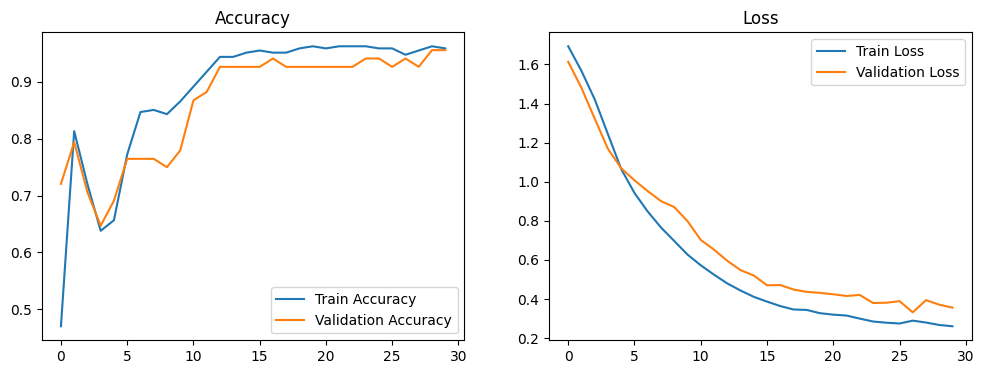

[array([[4.67202008e-05, 3.80381425e-05, 2.60287834e-05, 2.26988086e-05,
        1.21936528e-05, 2.37671502e-05, 2.84165890e-05, 1.27087318e-04,
        2.99726544e-05, 8.75666519e-05, 5.66552626e-05, 5.47289928e-05,
        2.12044415e-05, 2.65766539e-05, 1.94783133e-05, 7.96658132e-05,
        2.54804718e-06, 4.28364656e-05, 9.77285799e-06, 2.55578889e-05,
        6.53415336e-05, 9.80940331e-06, 9.44365001e-06, 1.73136505e-05,
        7.85943121e-05, 2.99948060e-05, 4.19589778e-05, 8.26608739e-05,
        7.29025269e-05, 3.88390035e-05, 5.18133274e-05, 4.72950160e-05,
        1.47537776e-05, 7.08462321e-05, 3.51867093e-05, 3.32808631e-05,
        3.22999549e-05, 2.20038983e-05, 3.21777734e-05, 6.43100211e-05,
        3.49227194e-05, 4.80419694e-05, 8.46332114e-05, 1.44039732e-05,
        7.32145854e-05, 2.96445487e-05, 2.16505250e-05, 1.35197615e-05,
        1.70293588e-05, 1.26793690e-04, 3.51336494e-05, 8.42648660e-05,
        1.17317886e-05, 1.79697199e-05, 2.49995755e-05, 1.53546

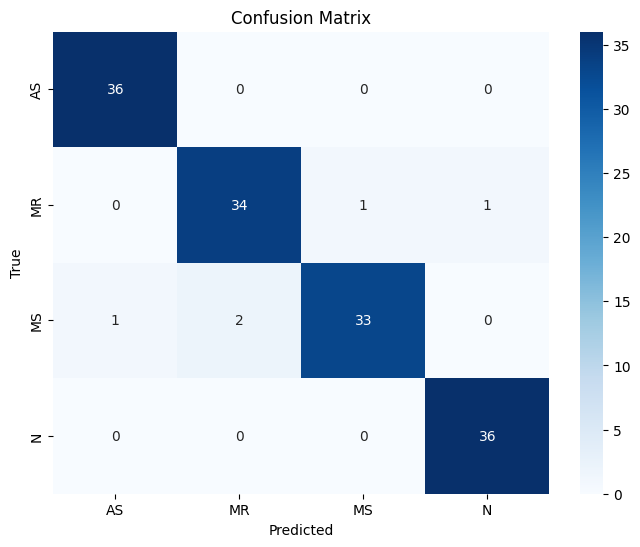

['AS' 'MR' 'MS' 'N']
Epoch 1/15, Loss: 0.8486, Accuracy: 0.7933, Val_Loss: 0.7185, Val_Accuracy: 0.7111
Epoch 2/15, Loss: 0.6594, Accuracy: 0.8994, Val_Loss: 0.4256, Val_Accuracy: 0.9333
Epoch 3/15, Loss: 0.5558, Accuracy: 0.9218, Val_Loss: 0.3373, Val_Accuracy: 0.9556
Epoch 4/15, Loss: 0.4997, Accuracy: 0.9162, Val_Loss: 0.3375, Val_Accuracy: 0.9556
Epoch 5/15, Loss: 0.4625, Accuracy: 0.9274, Val_Loss: 0.3204, Val_Accuracy: 0.9778
Epoch 6/15, Loss: 0.4345, Accuracy: 0.9274, Val_Loss: 0.3014, Val_Accuracy: 0.9556
Epoch 7/15, Loss: 0.4030, Accuracy: 0.9385, Val_Loss: 0.2788, Val_Accuracy: 0.9778
Epoch 8/15, Loss: 0.3777, Accuracy: 0.9441, Val_Loss: 0.2625, Val_Accuracy: 0.9778
Epoch 9/15, Loss: 0.3576, Accuracy: 0.9553, Val_Loss: 0.2502, Val_Accuracy: 0.9778
Epoch 10/15, Loss: 0.3433, Accuracy: 0.9553, Val_Loss: 0.2433, Val_Accuracy: 1.0000
Epoch 11/15, Loss: 0.3320, Accuracy: 0.9553, Val_Loss: 0.2371, Val_Accuracy: 1.0000
Epoch 12/15, Loss: 0.3218, Accuracy: 0.9609, Val_Loss: 0.2288, V

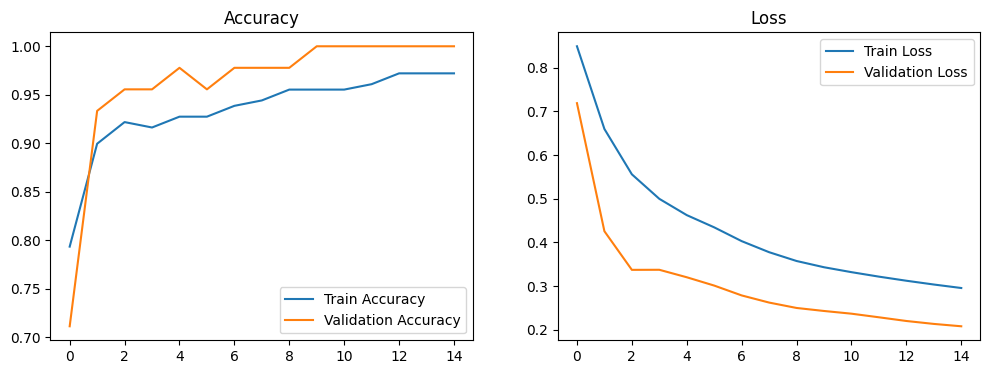

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
              precision    recall  f1-score   support

          AS       0.92      0.97      0.95        36
          MR       1.00      0.67      0.80        36
          MS       0.80      0.97      0.88        36
           N       0.95      1.00      0.97        36

    accuracy                           0.90       144
   macro avg       0.92      0.90      0.90       144
weighted avg       0.92      0.90      0.90       144

BiLSTM Test Accuracy: 0.9027777777777778


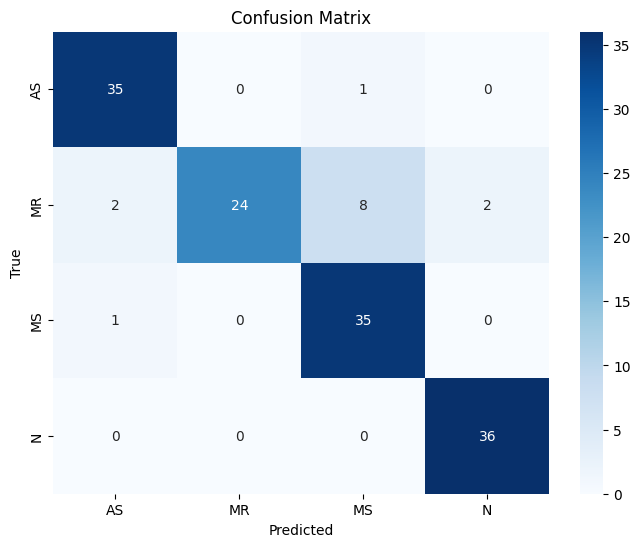

Skipping SMOTE: Only one class detected in y_train_spectrogram.
Skipping SMOTE: Only one class detected in y_train_mfcc.
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0.]
Class Mapping in Label Encoder:
AS: 0
MR: 1
MS: 2
N: 3
MVP: 4
🔹 Combined X_train shape: (252, 13, 1)
🔹 Combined y_train shape: (252, 5)
🔵 Adding new label: Current num_classes = 4, Incrementing by 1.
✅ Old Weights Stored Successfully!
✅ Old Output Layer Weights Retrieved
Old Output Layer Weights Shape: [(256, 4), (4,)]
✅ Created New Output Layer with 5 Classes
🔄 Applying layer 0: bidirectional_14 (Bidirectional)
🔄 Applying layer 1: bidirectional_15 (Bidirectional)
✅ Model Architecture Updated Successfully!
✅ Weights Transferred to Layer: input_layer_7
✅ Weights Transferred to Layer: bidirectional_14
✅ Weights Transferred to Layer: bidirectional_15
🔍 Processing Old Weight 0: Shape (256, 4)
✅ New Weight 0 Shape: (256, 5)
🔍 Processing Old Weight 1: Shape (4,)
✅ New Weight 1 Shape: (5,)
🔍 Final New Output Weights Shape: 

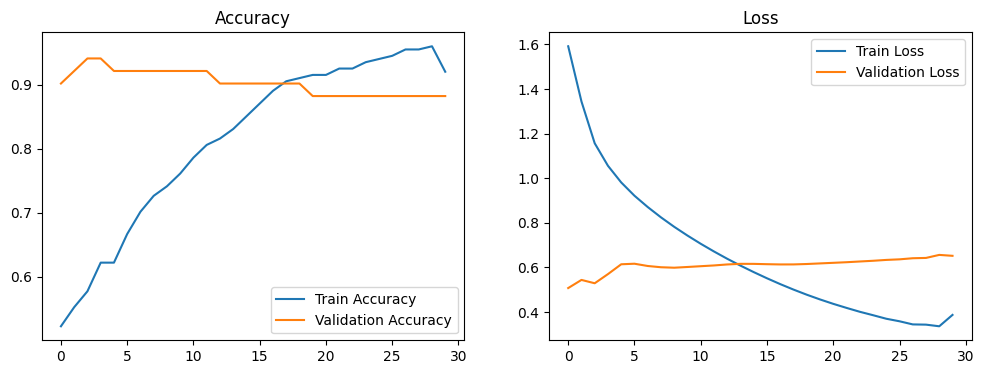

🚀 Incremental Training Complete!
[1. 0. 0. 0. 0.]
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
              precision    recall  f1-score   support

          AS       0.97      0.97      0.97        36
          MR       0.93      0.75      0.83        36
          MS       0.85      0.97      0.91        36
           N       0.97      0.92      0.94        36
         MVP       0.80      0.89      0.84        36

    accuracy                           0.90       180
   macro avg       0.91      0.90      0.90       180
weighted avg       0.91      0.90      0.90       180

BiLSTM Test Accuracy: 0.9


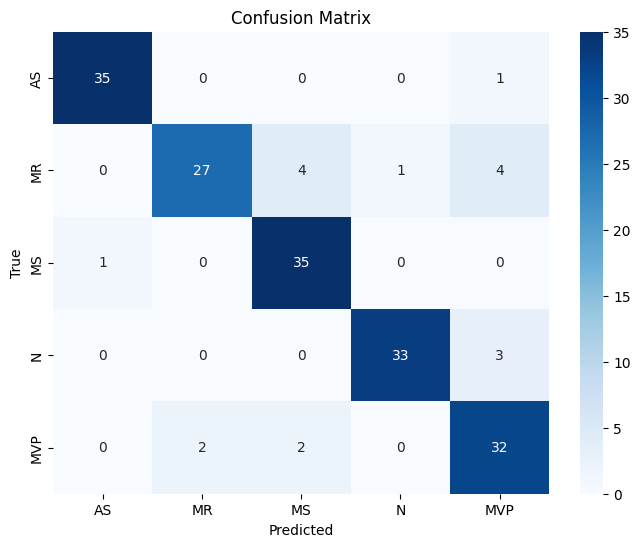

In [ ]:
import pickle
initial_csv_path  = r"..\Dataset\base_audio_mfcc_features_with_labels.csv"
X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, \
X_train_spectrogram, y_train_spectrogram, X_test_spectrogram, y_test_spectrogram, \
label_encoder, datagen = SplitDataset(initial_csv_path)
# Example to use only MFCC data.
input_shape = (X_train_mfcc.shape[1], 1)
num_classes = y_train_mfcc.shape[1]

model = IncrementalBiLSTM(input_shape, num_classes, l2_reg=0.0005)
model.train_initial(X_train_mfcc, np.argmax(y_train_mfcc, axis=1))
model.evaluate_model(X_test_mfcc, np.argmax(y_test_mfcc, axis=1), label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Save the model
model.model.save("bilstm_v2_model.h5")
with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

incremental_csv_path = r"..\Dataset\inc_audio_mfcc_features_with_labels.csv"

inc_train_x_mfcc, inc_train_y_mfcc, inc_test_mfcc, _, _, _, _, _, upd_label_encoder, _ = SplitDataset(incremental_csv_path, loaded_label_encoder)
print(upd_label_encoder.classes_)
model.train_incremental(inc_train_x_mfcc, np.argmax(inc_train_y_mfcc, axis=1), validation_split=0.2) #use incremental train function.
model.evaluate_model(X_test_mfcc, np.argmax(y_test_mfcc, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)

with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

mvp_csv_path = r"..\Dataset\continuous_audio_mfcc_features_with_labels.csv"
mvp_train_x_mfcc, mvp_train_y_mfcc, mvp_test_x_mfcc, mvp_test_y_mfcc, _, _, _, _, upd_label_encoder, _ = SplitDataset(mvp_csv_path, loaded_label_encoder)

def sample_data(X, y, sample_ratio=0.3):
    """Randomly selects a percentage of the data."""
    sample_size = int(len(X) * sample_ratio)  # Calculate 40% of the data
    indices = np.random.choice(len(X), sample_size, replace=False)  # Randomly select indices
    return X[indices], y[indices]  # Return sampled data

old_x_train_mfcc,old_y_train_mfcc,old_x_test_mfcc, old_y_test_mfcc, _,_,_,_,upd_label_encoder, _ = SplitDataset(initial_csv_path, upd_label_encoder)
print(old_y_train_mfcc[3])
old_x_sample, old_y_sample = sample_data(old_x_train_mfcc, old_y_train_mfcc, sample_ratio=0.3)

print(old_y_sample[3])
print(old_y_test_mfcc[12])

print("Class Mapping in Label Encoder:")
for class_name, encoded_value in zip(upd_label_encoder.classes_, range(len(upd_label_encoder.classes_))):
    print(f"{class_name}: {encoded_value}")

combined_x_train = np.concatenate((mvp_train_x_mfcc, old_x_sample), axis=0)
combined_y_train = np.concatenate((mvp_train_y_mfcc, old_y_sample), axis=0)

# Debug: Print shapes before training
print(f"🔹 Combined X_train shape: {combined_x_train.shape}")
print(f"🔹 Combined y_train shape: {combined_y_train.shape}")

# Use the combined dataset for incremental learning
model.add_new_label(combined_x_train, np.argmax(combined_y_train, axis=1)) 

# Ensure all arrays are NumPy arrays
print(old_y_test_mfcc[12])
X_combined_test = np.concatenate((old_x_test_mfcc, mvp_test_x_mfcc), axis=0)
y_combined_test = np.concatenate((old_y_test_mfcc, mvp_test_y_mfcc), axis=0)

# Evaluate the model with the combined test set
model.evaluate_model(X_combined_test, np.argmax(y_combined_test, axis=1), upd_label_encoder)

# model.evaluate_model(mvp_test_x_mfcc, np.argmax(mvp_test_y_mfcc, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)


## LSTM

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

class IncrementalLSTM:
    def __init__(self, input_shape, num_classes, lstm_units=128, learning_rate=0.0002, l2_reg=0.001):  # Added l2_reg parameter
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.lstm_units = lstm_units
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg  # Store the L2 regularization value
        self.model = self.build_model()
        self.fisher_matrix = None
        self.previous_weights = None

    def build_model(self):
        input_layer = layers.Input(shape=self.input_shape)
        lstm1 = layers.LSTM(self.lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(self.l2_reg))(input_layer)
        lstm2 = layers.LSTM(self.lstm_units, kernel_regularizer=regularizers.l2(self.l2_reg))(lstm1)
        output_layer = layers.Dense(self.num_classes, activation='softmax', kernel_regularizer=regularizers.l2(self.l2_reg))(lstm2)

        model = models.Model(inputs=input_layer, outputs=output_layer)

        model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                      loss=losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model

    def train_initial(self, X_train, y_train, epochs=30, batch_size=32, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        history = self.model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size,validation_split=validation_split, verbose=1)
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.previous_weights = self.model.get_weights()
        self.plot_training_history(history)
        print(self.fisher_matrix)
    
    def calculate_fisher_matrix(self, X_train, y_train_one_hot):
        fisher_matrices = [np.zeros_like(weight.numpy()) for weight in self.model.trainable_weights]

        for i in range(len(X_train)):
            with tf.GradientTape() as tape:
                predictions = self.model(np.expand_dims(X_train[i], axis=0))
                loss = losses.categorical_crossentropy(np.expand_dims(y_train_one_hot[i], axis=0), predictions)

            gradients = tape.gradient(loss, self.model.trainable_weights)
            for j, grad in enumerate(gradients):
                if grad is not None:  # Ensure grad is not None (e.g., for unused weights)
                    fisher_matrices[j] += np.square(grad.numpy())

        # Normalize Fisher matrix
        fisher_matrices = [fisher / len(X_train) for fisher in fisher_matrices]
        self.fisher_matrix = fisher_matrices


    def train_incremental(self, X_train, y_train, epochs=30, batch_size=32, ewc_lambda=5.0, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        optimizer = optimizers.Adam(learning_rate=self.learning_rate)

        # Split data for validation
        train_size = int(len(X_train) * (1 - validation_split))
        X_train_train, X_val = X_train[:train_size], X_train[train_size:]
        y_train_train, y_val = y_train_one_hot[:train_size], y_train_one_hot[train_size:]

        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(epochs):
            for batch_start in range(0, len(X_train_train), batch_size):
                batch_end = batch_start + batch_size
                batch_X = X_train_train[batch_start:batch_end]
                batch_y = y_train_train[batch_start:batch_end]

                with tf.GradientTape() as tape:
                    predictions = self.model(batch_X, training=True)
                    loss = losses.categorical_crossentropy(batch_y, predictions)

                    # EWC regularization
                    if self.fisher_matrix and self.previous_weights:
                        ewc_loss = 0.0
                        for i, weight in enumerate(self.model.trainable_weights):
                            # Skip output layer weights in EWC calculation
                            if weight.shape != self.previous_weights[i].shape:
                                continue
                            ewc_loss += ewc_lambda * tf.reduce_sum(self.fisher_matrix[i] * tf.square(weight - self.previous_weights[i]))
                        loss += ewc_loss

                gradients = tape.gradient(loss, self.model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

            # Evaluate on training and validation sets
            train_loss, train_acc = self.model.evaluate(X_train_train, y_train_train, verbose=0)
            val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)

            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc:.4f}")

        self.previous_weights = self.model.get_weights()
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.ewc_plot_training_history(history)
        # print("Changed fisher matrix: ", self.fisher_matrix)

    def add_new_label(self, X_train, y_train, X_old=None, y_old=None, epochs=30, batch_size=32, ewc_lambda=7.0):
        """Adds a new label to the model incrementally, updating the output layer."""
        
        print(f"🔵 Adding new label: Current num_classes = {self.num_classes}, Incrementing by 1.")
        self.num_classes += 1  # Increment class count

        # Store existing weights
        old_weights = {layer.name: layer.get_weights() for layer in self.model.layers}
        print("✅ Old Weights Stored Successfully!")

        # Remove old output layer
        old_output_layer = self.model.layers[-1]
        old_output_weights = old_output_layer.get_weights()
        print(f"✅ Old Output Layer Weights Retrieved\nOld Output Layer Weights Shape: {[w.shape for w in old_output_weights]}")

        # Create a new output layer with one additional neuron
        new_output_layer = layers.Dense(self.num_classes, activation='softmax', 
                                        kernel_regularizer=regularizers.l2(self.l2_reg), 
                                        name='new_output_layer')

        print(f"✅ Created New Output Layer with {self.num_classes} Classes")

        # Rebuild model with modified architecture
        input_tensor = self.model.input
        x = input_tensor
        for i, layer in enumerate(self.model.layers[1:-1]):  # Exclude last (output) layer
            print(f"🔄 Applying layer {i}: {layer.name} ({layer.__class__.__name__})")
            try:
                x = layer(x)
            except Exception as e:
                print(f"🚨 Error at layer {i}: {layer.name} - {e}")
                return  # Stop execution if an error occurs

        output_tensor = new_output_layer(x)  # Attach the new output layer
        self.model = models.Model(inputs=input_tensor, outputs=output_tensor)
        print("✅ Model Architecture Updated Successfully!")

        # Transfer weights to new layers (except output layer)
        for layer in self.model.layers[:-1]:
            if layer.name in old_weights:
                layer.set_weights(old_weights[layer.name])
                print(f"✅ Weights Transferred to Layer: {layer.name}")

        # Initialize the new output layer with old weights + random values for the new class
        new_output_weights = []
        for i, old_w in enumerate(old_output_weights):
            print(f"🔍 Processing Old Weight {i}: Shape {old_w.shape}")
            
            if old_w.ndim == 2:  # Weight matrix
                new_w = np.concatenate([old_w, np.random.normal(0, 0.01, (old_w.shape[0], 1))], axis=1)
            elif old_w.ndim == 1:  # Bias vector
                new_w = np.concatenate([old_w, np.zeros((1,))], axis=0)
            else:
                print(f"🚨 Unexpected Shape in Weights: {old_w.shape}")
                return  # Stop execution if an error occurs
            
            # print(f"✅ New Weight {i} Shape: {new_w.shape}")
            new_output_weights.append(new_w)

        # print(f"🔍 Final New Output Weights Shape: {[w.shape for w in new_output_weights]}")
        
        # Set new weights for the output layer
        try:
            new_output_layer.set_weights(new_output_weights)
            print("✅ New Output Layer Weights Set Successfully!")
        except ValueError as e:
            print(f"🚨 Weight Assignment Error: {e}")
            return

        # Recompile model
        self.learning_rate=0.00035
        self.model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                        loss=losses.CategoricalCrossentropy(),
                        metrics=['accuracy'])
        print("✅ Model Compiled Successfully!")

        # Adjust new labels
        y_train_adjusted = y_train + (self.num_classes - 1 - np.max(y_train))
        # print(f"🔄 Adjusted Labels: min={y_train_adjusted.min()}, max={y_train_adjusted.max()}")

        # Merge old and new data
        if X_old is not None and y_old is not None:
            X_combined = np.concatenate((X_train, X_old), axis=0)
            y_combined = np.concatenate((y_train_adjusted, y_old), axis=0)
            print(f"✅ Combined Data: X shape {X_combined.shape}, y shape {y_combined.shape}")
        else:
            X_combined = X_train
            y_combined = y_train_adjusted
            # print(f"✅ Using Only New Data: X shape {X_combined.shape}, y shape {y_combined.shape}")

        # Train the model incrementally
        self.train_incremental(X_combined, y_combined, epochs, batch_size, ewc_lambda)
        print("🚀 Incremental Training Complete!")

    def plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()

    def evaluate_model(self, X_test, y_test, label_encoder): #updated function to accept label_encoder
        y_pred_probs = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        print(classification_report(y_test, y_pred, target_names=label_encoder.inverse_transform(np.unique(y_test))))
        print(f"CNN Test Accuracy: {np.mean(y_pred == y_test)}")

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform(np.unique(y_test)), yticklabels=label_encoder.inverse_transform(np.unique(y_test)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def ewc_plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.2843 - loss: 1.4749 - val_accuracy: 0.7206 - val_loss: 1.4188
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6298 - loss: 1.4193 - val_accuracy: 0.7647 - val_loss: 1.3484
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6797 - loss: 1.3519 - val_accuracy: 0.7941 - val_loss: 1.2560
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6879 - loss: 1.2625 - val_accuracy: 0.8088 - val_loss: 1.1349
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6636 - loss: 1.1344 - val_accuracy: 0.7941 - val_loss: 0.9971
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6049 - loss: 1.0329 - val_accuracy: 0.7647 - val_loss: 0.8854
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6097 - loss: 0.9306 - val_accuracy: 0.7794 - val_loss: 0.8230
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7128 - loss: 0.8568 - val_accuracy: 0.8088 - val_loss: 0.7762


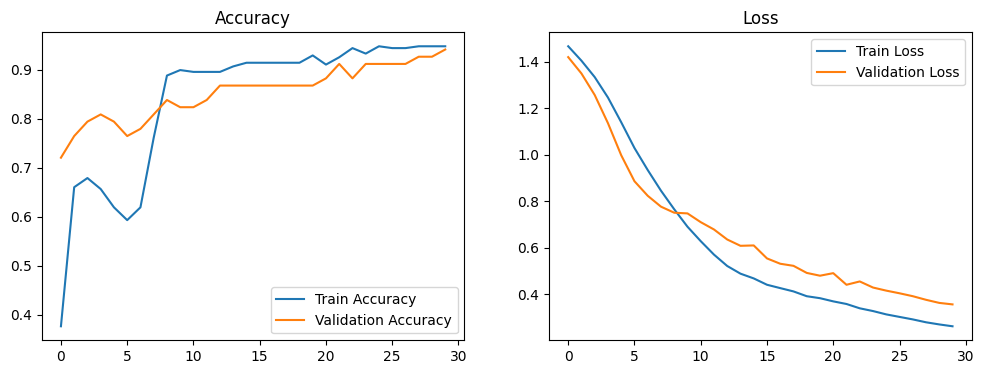

[array([[9.59870704e-06, 2.55424729e-05, 4.34442336e-05, 6.30694121e-05,
        1.32697955e-04, 2.54952902e-05, 7.57044545e-05, 7.01919853e-05,
        5.48794305e-05, 2.15485143e-05, 5.21656533e-04, 7.60731928e-05,
        5.42976377e-05, 5.67144198e-05, 5.29033059e-05, 1.43555444e-05,
        2.12240302e-05, 1.00372650e-04, 7.46554870e-05, 5.12154911e-05,
        2.34193009e-04, 7.07084910e-05, 3.25085239e-05, 3.71917049e-05,
        1.53721834e-04, 3.22925298e-05, 5.19141831e-05, 7.29672029e-05,
        1.70747371e-04, 1.75154419e-04, 7.99056579e-05, 4.25266597e-04,
        2.44178664e-04, 2.53057951e-05, 3.50503215e-05, 5.96848200e-04,
        4.74629705e-05, 5.28300552e-05, 2.60585966e-05, 1.03421757e-04,
        3.81689752e-04, 1.15175599e-05, 1.68809551e-04, 4.10406392e-05,
        1.38743460e-04, 5.21669936e-05, 5.26595395e-05, 1.36290200e-05,
        4.31178560e-05, 1.84309654e-04, 2.23520146e-05, 5.45729335e-06,
        3.51229573e-05, 2.14984793e-05, 2.10931121e-05, 1.75503

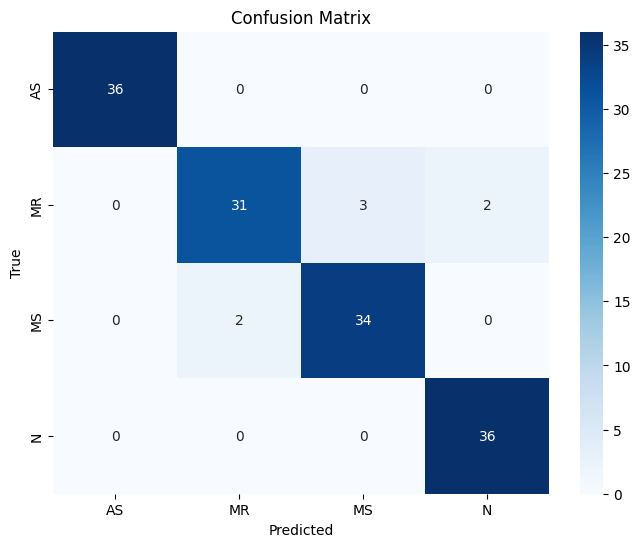

['AS' 'MR' 'MS' 'N']
Epoch 1/30, Loss: 0.8720, Accuracy: 0.7430, Val_Loss: 0.8146, Val_Accuracy: 0.7333
Epoch 2/30, Loss: 0.7409, Accuracy: 0.7989, Val_Loss: 0.7551, Val_Accuracy: 0.7556
Epoch 3/30, Loss: 0.6825, Accuracy: 0.7877, Val_Loss: 0.7483, Val_Accuracy: 0.7556
Epoch 4/30, Loss: 0.6415, Accuracy: 0.7821, Val_Loss: 0.7181, Val_Accuracy: 0.7556
Epoch 5/30, Loss: 0.6019, Accuracy: 0.7933, Val_Loss: 0.6664, Val_Accuracy: 0.7556
Epoch 6/30, Loss: 0.5641, Accuracy: 0.8101, Val_Loss: 0.6114, Val_Accuracy: 0.7778
Epoch 7/30, Loss: 0.5293, Accuracy: 0.7933, Val_Loss: 0.5640, Val_Accuracy: 0.7556
Epoch 8/30, Loss: 0.4966, Accuracy: 0.7989, Val_Loss: 0.5238, Val_Accuracy: 0.7778
Epoch 9/30, Loss: 0.4637, Accuracy: 0.8212, Val_Loss: 0.4874, Val_Accuracy: 0.8222
Epoch 10/30, Loss: 0.4320, Accuracy: 0.8827, Val_Loss: 0.4544, Val_Accuracy: 0.8667
Epoch 11/30, Loss: 0.4038, Accuracy: 0.9106, Val_Loss: 0.4251, Val_Accuracy: 0.8667
Epoch 12/30, Loss: 0.3820, Accuracy: 0.9330, Val_Loss: 0.3987, V

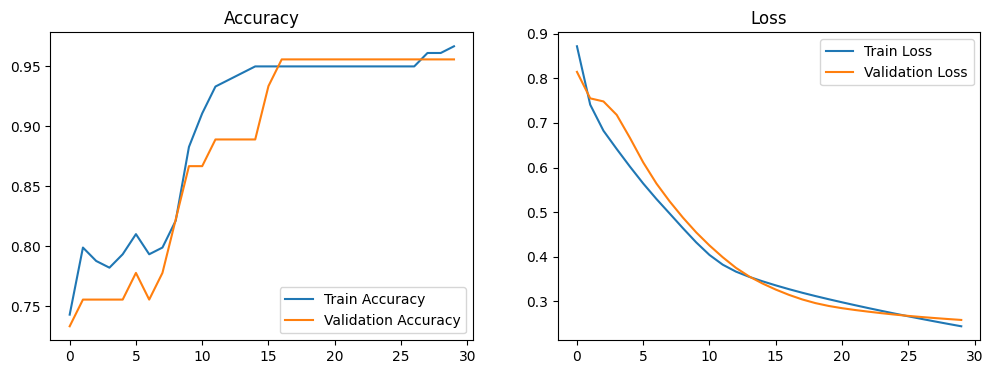

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

          AS       0.62      0.97      0.76        36
          MR       1.00      0.53      0.69        36
          MS       0.77      0.94      0.85        36
           N       0.92      0.64      0.75        36

    accuracy                           0.77       144
   macro avg       0.83      0.77      0.76       144
weighted avg       0.83      0.77      0.76       144

LSTM Test Accuracy: 0.7708333333333334


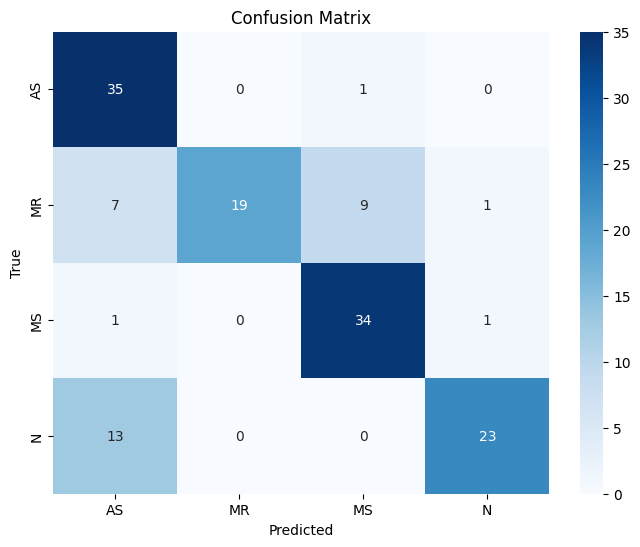

Skipping SMOTE: Only one class detected in y_train_spectrogram.
Skipping SMOTE: Only one class detected in y_train_mfcc.
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
Class Mapping in Label Encoder:
AS: 0
MR: 1
MS: 2
N: 3
MVP: 4
🔹 Combined X_train shape: (218, 13, 1)
🔹 Combined y_train shape: (218, 5)
🔵 Adding new label: Current num_classes = 4, Incrementing by 1.
✅ Old Weights Stored Successfully!
✅ Old Output Layer Weights Retrieved
Old Output Layer Weights Shape: [(128, 4), (4,)]
✅ Created New Output Layer with 5 Classes
🔄 Applying layer 0: lstm_12 (LSTM)
🔄 Applying layer 1: lstm_13 (LSTM)
✅ Model Architecture Updated Successfully!
✅ Weights Transferred to Layer: input_layer_8
✅ Weights Transferred to Layer: lstm_12
✅ Weights Transferred to Layer: lstm_13
🔍 Processing Old Weight 0: Shape (128, 4)
🔍 Processing Old Weight 1: Shape (4,)
🔍 Final New Output Weights Shape: [(128, 5), (5,)]
✅ New Output Layer Weights Set Successfully!
✅ Model Compiled Successfully!
🔄 Adjusted Labels: 

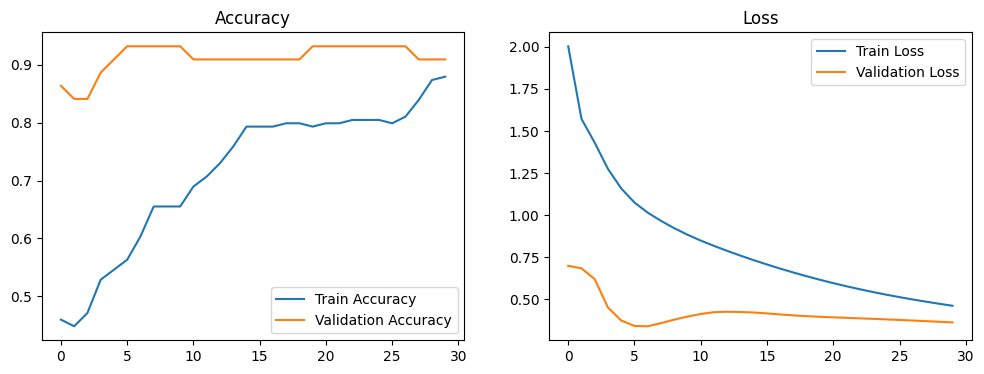

🚀 Incremental Training Complete!
[1. 0. 0. 0. 0.]
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
              precision    recall  f1-score   support

          AS       0.97      0.94      0.96        36
          MR       0.84      0.72      0.78        36
          MS       0.89      0.92      0.90        36
           N       1.00      0.92      0.96        36
         MVP       0.68      0.83      0.75        36

    accuracy                           0.87       180
   macro avg       0.88      0.87      0.87       180
weighted avg       0.88      0.87      0.87       180

LSTM Test Accuracy: 0.8666666666666667


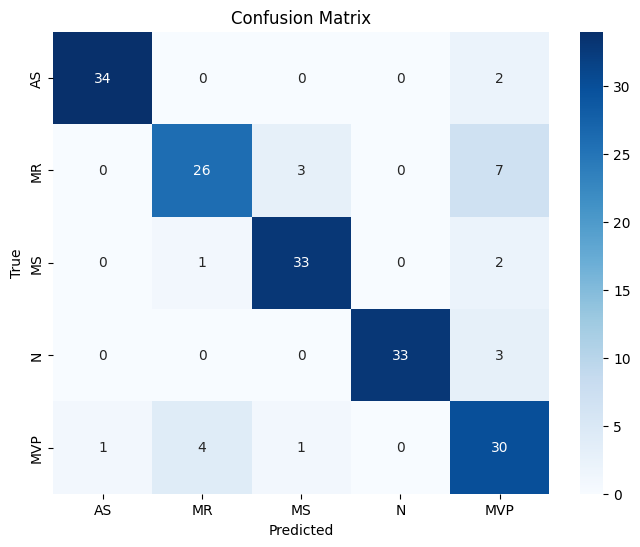

In [ ]:
import pickle
initial_csv_path  = r"..\Dataset\base_audio_mfcc_features_with_labels.csv"
X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, \
X_train_spectrogram, y_train_spectrogram, X_test_spectrogram, y_test_spectrogram, \
label_encoder, datagen = SplitDataset(initial_csv_path)
# Example to use only MFCC data.
input_shape = (X_train_mfcc.shape[1], 1)
num_classes = y_train_mfcc.shape[1]

model = IncrementalLSTM(input_shape, num_classes, l2_reg=0.0005)
model.train_initial(X_train_mfcc, np.argmax(y_train_mfcc, axis=1))
model.evaluate_model(X_test_mfcc, np.argmax(y_test_mfcc, axis=1), label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Save the model
model.model.save("cnn_v2_model.h5")
with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

incremental_csv_path = r"..\Dataset\inc_audio_mfcc_features_with_labels.csv"

inc_train_x_mfcc, inc_train_y_mfcc, inc_test_mfcc, _, _, _, _, _, upd_label_encoder, _ = SplitDataset(incremental_csv_path, loaded_label_encoder)
print(upd_label_encoder.classes_)
model.train_incremental(inc_train_x_mfcc, np.argmax(inc_train_y_mfcc, axis=1), validation_split=0.2) #use incremental train function.
model.evaluate_model(X_test_mfcc, np.argmax(y_test_mfcc, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)

with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

mvp_csv_path = r"..\Dataset\continuous_audio_mfcc_features_with_labels.csv"
mvp_train_x_mfcc, mvp_train_y_mfcc, mvp_test_x_mfcc, mvp_test_y_mfcc, _, _, _, _, upd_label_encoder, _ = SplitDataset(mvp_csv_path, loaded_label_encoder)

def sample_data(X, y, sample_ratio=0.2):
    """Randomly selects a percentage of the data."""
    sample_size = int(len(X) * sample_ratio)  # Calculate 40% of the data
    indices = np.random.choice(len(X), sample_size, replace=False)  # Randomly select indices
    return X[indices], y[indices]  # Return sampled data

old_x_train_mfcc,old_y_train_mfcc,old_x_test_mfcc, old_y_test_mfcc, _,_,_,_,upd_label_encoder, _ = SplitDataset(initial_csv_path, upd_label_encoder)
print(old_y_train_mfcc[3])
old_x_sample, old_y_sample = sample_data(old_x_train_mfcc, old_y_train_mfcc, sample_ratio=0.3)

print(old_y_sample[3])
print(old_y_test_mfcc[12])

print("Class Mapping in Label Encoder:")
for class_name, encoded_value in zip(upd_label_encoder.classes_, range(len(upd_label_encoder.classes_))):
    print(f"{class_name}: {encoded_value}")

combined_x_train = np.concatenate((mvp_train_x_mfcc, old_x_sample), axis=0)
combined_y_train = np.concatenate((mvp_train_y_mfcc, old_y_sample), axis=0)

# Debug: Print shapes before training
print(f"🔹 Combined X_train shape: {combined_x_train.shape}")
print(f"🔹 Combined y_train shape: {combined_y_train.shape}")

# Use the combined dataset for incremental learning
model.add_new_label(combined_x_train, np.argmax(combined_y_train, axis=1)) 

# Ensure all arrays are NumPy arrays
print(old_y_test_mfcc[12])
X_combined_test = np.concatenate((old_x_test_mfcc, mvp_test_x_mfcc), axis=0)
y_combined_test = np.concatenate((old_y_test_mfcc, mvp_test_y_mfcc), axis=0)

# Evaluate the model with the combined test set
model.evaluate_model(X_combined_test, np.argmax(y_combined_test, axis=1), upd_label_encoder)

# model.evaluate_model(mvp_test_x_mfcc, np.argmax(mvp_test_y_mfcc, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)


## CNN

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

class IncrementalCNN:
    def __init__(self, input_shape, num_classes, filters=128, kernel_size=3, learning_rate=0.0002, l2_reg=0.001):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.filters = filters
        self.kernel_size = kernel_size
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg  # Store the L2 regularization value
        self.model = self.build_model()
        self.fisher_matrix = None
        self.previous_weights = None

    def build_model(self):
        input_layer = layers.Input(shape=self.input_shape)
        
        # Convolutional Layers
        conv1 = layers.Conv1D(filters=self.filters, kernel_size=self.kernel_size, activation='relu', padding='same', kernel_regularizer=regularizers.l2(self.l2_reg))(input_layer)
        max_pool1 = layers.MaxPooling1D(pool_size=2)(conv1)
        
        conv2 = layers.Conv1D(filters=self.filters, kernel_size=self.kernel_size, activation='relu', padding='same', kernel_regularizer=regularizers.l2(self.l2_reg))(max_pool1)
        max_pool2 = layers.MaxPooling1D(pool_size=2)(conv2)

        # Flatten and Dense Layers
        flatten = layers.Flatten()(max_pool2)
        dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))(flatten)
        output_layer = layers.Dense(self.num_classes, activation='softmax', kernel_regularizer=regularizers.l2(self.l2_reg))(dense)

        model = models.Model(inputs=input_layer, outputs=output_layer)

        model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                      loss=losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model

    def train_initial(self, X_train, y_train, epochs=30, batch_size=32, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        history = self.model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=1)
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.previous_weights = self.model.get_weights()
        self.plot_training_history(history)
        print(self.fisher_matrix)
    
    def calculate_fisher_matrix(self, X_train, y_train_one_hot):
        fisher_matrices = [np.zeros_like(weight.numpy()) for weight in self.model.trainable_weights]

        for i in range(len(X_train)):
            with tf.GradientTape() as tape:
                predictions = self.model(np.expand_dims(X_train[i], axis=0))
                loss = losses.categorical_crossentropy(np.expand_dims(y_train_one_hot[i], axis=0), predictions)

            gradients = tape.gradient(loss, self.model.trainable_weights)
            for j, grad in enumerate(gradients):
                if grad is not None:
                    fisher_matrices[j] += np.square(grad.numpy())

        fisher_matrices = [fisher / len(X_train) for fisher in fisher_matrices]
        self.fisher_matrix = fisher_matrices

    def train_incremental(self, X_train, y_train, epochs=30, batch_size=32, ewc_lambda=7.0, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        optimizer = optimizers.Adam(learning_rate=self.learning_rate)

        train_size = int(len(X_train) * (1 - validation_split))
        X_train_train, X_val = X_train[:train_size], X_train[train_size:]
        y_train_train, y_val = y_train_one_hot[:train_size], y_train_one_hot[train_size:]

        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(epochs):
            for batch_start in range(0, len(X_train_train), batch_size):
                batch_end = batch_start + batch_size
                batch_X = X_train_train[batch_start:batch_end]
                batch_y = y_train_train[batch_start:batch_end]

                with tf.GradientTape() as tape:
                    predictions = self.model(batch_X, training=True)
                    loss = losses.categorical_crossentropy(batch_y, predictions)

                    if self.fisher_matrix and self.previous_weights:
                        ewc_loss = 0.0
                        for i, weight in enumerate(self.model.trainable_weights):
                            if weight.shape != self.previous_weights[i].shape:
                                continue
                            ewc_loss += ewc_lambda * tf.reduce_sum(self.fisher_matrix[i] * tf.square(weight - self.previous_weights[i]))
                        loss += ewc_loss

                gradients = tape.gradient(loss, self.model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

            train_loss, train_acc = self.model.evaluate(X_train_train, y_train_train, verbose=0)
            val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)

            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc:.4f}")

        self.previous_weights = self.model.get_weights()
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.ewc_plot_training_history(history)
        # print("Changed fisher matrix: ", self.fisher_matrix)

    def add_new_label(self, X_train, y_train, X_old=None, y_old=None, epochs=30, batch_size=16, ewc_lambda=5.0):
        print(f"🔵 Adding new label: Current num_classes = {self.num_classes}, Incrementing by 1.")
        self.num_classes += 1

        old_weights = {layer.name: layer.get_weights() for layer in self.model.layers}
        print("✅ Old Weights Stored Successfully!")

        old_output_layer = self.model.layers[-1]
        old_output_weights = old_output_layer.get_weights()
        print(f"✅ Old Output Layer Weights Retrieved")

        new_output_layer = layers.Dense(self.num_classes, activation='softmax', kernel_regularizer=regularizers.l2(self.l2_reg), name='new_output_layer')

        print(f"✅ Created New Output Layer with {self.num_classes} Classes")

        input_tensor = self.model.input
        x = input_tensor
        for i, layer in enumerate(self.model.layers[1:-1]):
            # print(f"🔄 Applying layer {i}: {layer.name}")
            try:
                x = layer(x)
            except Exception as e:
                # print(f"🚨 Error at layer {i}: {layer.name} - {e}")
                return

        output_tensor = new_output_layer(x)
        self.model = models.Model(inputs=input_tensor, outputs=output_tensor)
        print("✅ Model Architecture Updated Successfully!")

        for layer in self.model.layers[:-1]:
            if layer.name in old_weights:
                layer.set_weights(old_weights[layer.name])
                # print(f"✅ Weights Transferred to Layer: {layer.name}")

        new_output_weights = []
        for i, old_w in enumerate(old_output_weights):
            if old_w.ndim == 2:
                new_w = np.concatenate([old_w, np.random.normal(0, 0.01, (old_w.shape[0], 1))], axis=1)
            elif old_w.ndim == 1:
                new_w = np.concatenate([old_w, np.zeros((1,))], axis=0)

            new_output_weights.append(new_w)

        try:
            new_output_layer.set_weights(new_output_weights)
            print("✅ New Output Layer Weights Set Successfully!")
        except ValueError as e:
            print(f"🚨 Weight Assignment Error: {e}")
            return

        self.learning_rate = 0.00015
        self.model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                           loss=losses.CategoricalCrossentropy(),
                           metrics=['accuracy'])
        print("✅ Model Compiled Successfully!")

        y_train_adjusted = y_train + (self.num_classes - 1 - np.max(y_train))
        print(f"🔄 Adjusted Labels: min={y_train_adjusted.min()}, max={y_train_adjusted.max()}")

        if X_old is not None and y_old is not None:
            X_combined = np.concatenate((X_train, X_old), axis=0)
            y_combined = np.concatenate((y_train_adjusted, y_old), axis=0)
            # print(f"✅ Combined Data: X shape {X_combined.shape}, y shape {y_combined.shape}")
        else:
            X_combined = X_train
            y_combined = y_train_adjusted
            # print(f"✅ Using Only New Data: X shape {X_combined.shape}, y shape {y_combined.shape}")

        self.train_incremental(X_combined, y_combined, epochs, batch_size, ewc_lambda)
        print("🚀 Incremental Training Complete!")

    def plot_training_history(self, history): 
        if history is None:
            return

        history_dict = history.history  # Extract history as a dictionary

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history_dict.get('accuracy', []), label='Train Accuracy')
        if 'val_accuracy' in history_dict:
            plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history_dict.get('loss', []), label='Train Loss')
        if 'val_loss' in history_dict:
            plt.plot(history_dict['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')

        plt.show()


    def evaluate_model(self, X_test, y_test, label_encoder): #updated function to accept label_encoder
        y_pred_probs = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        print(classification_report(y_test, y_pred, target_names=label_encoder.inverse_transform(np.unique(y_test))))
        print(f"CNN Test Accuracy: {np.mean(y_pred == y_test)}")

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform(np.unique(y_test)), yticklabels=label_encoder.inverse_transform(np.unique(y_test)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def ewc_plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()

             

Final X_train_mfcc shape: (336, 13, 1)
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5006 - loss: 1.5590 - val_accuracy: 0.7647 - val_loss: 1.4043
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6515 - loss: 1.3964 - val_accuracy: 0.7794 - val_loss: 1.2411
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6548 - loss: 1.2459 - val_accuracy: 0.8088 - val_loss: 1.0874
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7365 - loss: 1.0915 - val_accuracy: 0.8235 - val_loss: 0.9404
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7272 - loss: 0.9593 - val_accuracy: 0.8529 - val_loss: 0.8276
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7986 - loss: 0.8498 - val_accuracy: 0.8676 - val_loss: 0.7400
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8394 - loss: 0.7546 - val_accuracy: 0.9265 - val_loss: 0.6757
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9098 - loss: 0.6956 - v

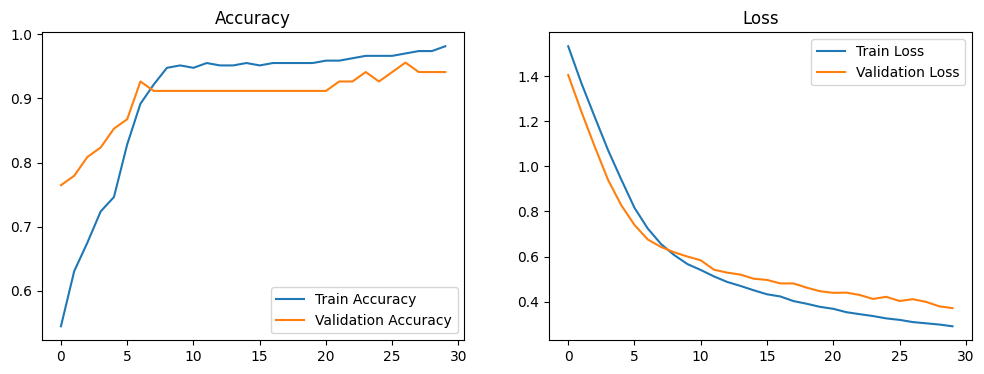

[array([[[0.0003646 , 0.00291098, 0.00414397, 0.00411048, 0.01422221,
         0.00426297, 0.00242402, 0.0032688 , 0.00483348, 0.00870871,
         0.0037982 , 0.00865645, 0.00085909, 0.00078551, 0.01685014,
         0.00544173, 0.00077414, 0.00099332, 0.00773826, 0.00186402,
         0.01366697, 0.01569487, 0.00384383, 0.00785882, 0.00540284,
         0.00117425, 0.01784276, 0.00591027, 0.0025562 , 0.00538155,
         0.00301149, 0.0016293 , 0.00610462, 0.00387208, 0.00329201,
         0.00344196, 0.00098237, 0.00177244, 0.00953319, 0.01157948,
         0.00400698, 0.01126959, 0.00400202, 0.00250191, 0.00591703,
         0.00294993, 0.00315522, 0.00161484, 0.00217041, 0.00362261,
         0.00320084, 0.00778298, 0.00692762, 0.00102895, 0.00218162,
         0.00159394, 0.00404022, 0.00211053, 0.00398394, 0.00611676,
         0.006185  , 0.0068806 , 0.00227777, 0.0009367 , 0.00325418,
         0.00444396, 0.00181605, 0.00659576, 0.00239462, 0.01522455,
         0.00516293, 0.01134971, 

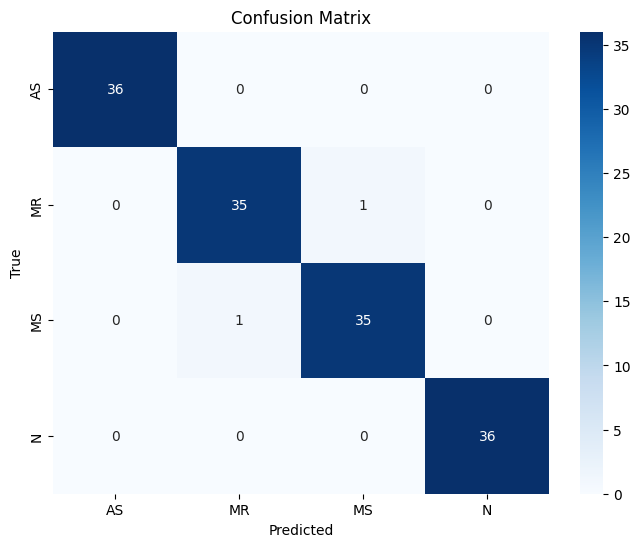

['AS' 'MR' 'MS' 'N']
Epoch 1/30, Loss: 0.8029, Accuracy: 0.7486, Val_Loss: 0.9673, Val_Accuracy: 0.6889
Epoch 2/30, Loss: 0.6604, Accuracy: 0.8324, Val_Loss: 0.9489, Val_Accuracy: 0.7556
Epoch 3/30, Loss: 0.5726, Accuracy: 0.9162, Val_Loss: 0.8512, Val_Accuracy: 0.8222
Epoch 4/30, Loss: 0.5331, Accuracy: 0.9106, Val_Loss: 0.7590, Val_Accuracy: 0.8000
Epoch 5/30, Loss: 0.5056, Accuracy: 0.9218, Val_Loss: 0.7194, Val_Accuracy: 0.8000
Epoch 6/30, Loss: 0.4823, Accuracy: 0.9385, Val_Loss: 0.6911, Val_Accuracy: 0.8222
Epoch 7/30, Loss: 0.4573, Accuracy: 0.9441, Val_Loss: 0.6297, Val_Accuracy: 0.8222
Epoch 8/30, Loss: 0.4362, Accuracy: 0.9497, Val_Loss: 0.5648, Val_Accuracy: 0.8222
Epoch 9/30, Loss: 0.4187, Accuracy: 0.9553, Val_Loss: 0.5254, Val_Accuracy: 0.8444
Epoch 10/30, Loss: 0.4034, Accuracy: 0.9665, Val_Loss: 0.4998, Val_Accuracy: 0.8444
Epoch 11/30, Loss: 0.3888, Accuracy: 0.9665, Val_Loss: 0.4711, Val_Accuracy: 0.8444
Epoch 12/30, Loss: 0.3754, Accuracy: 0.9777, Val_Loss: 0.4434, V

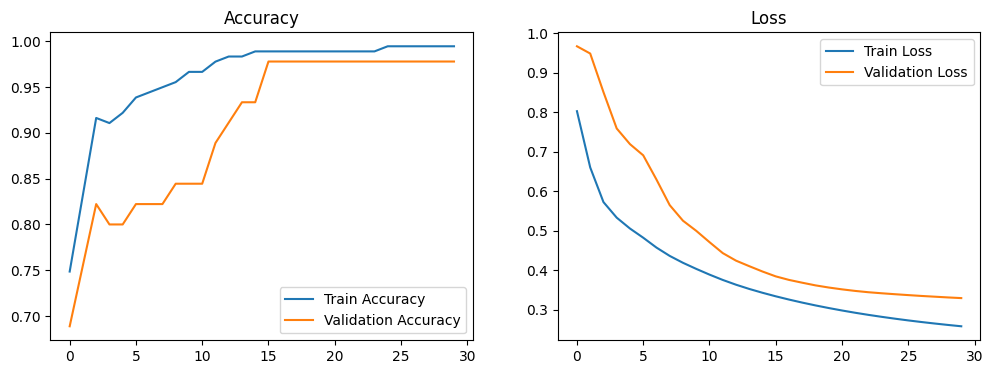

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

          AS       0.92      1.00      0.96        36
          MR       1.00      0.72      0.84        36
          MS       0.81      0.94      0.87        36
           N       0.97      1.00      0.99        36

    accuracy                           0.92       144
   macro avg       0.93      0.92      0.91       144
weighted avg       0.93      0.92      0.91       144

CNN Test Accuracy: 0.9166666666666666


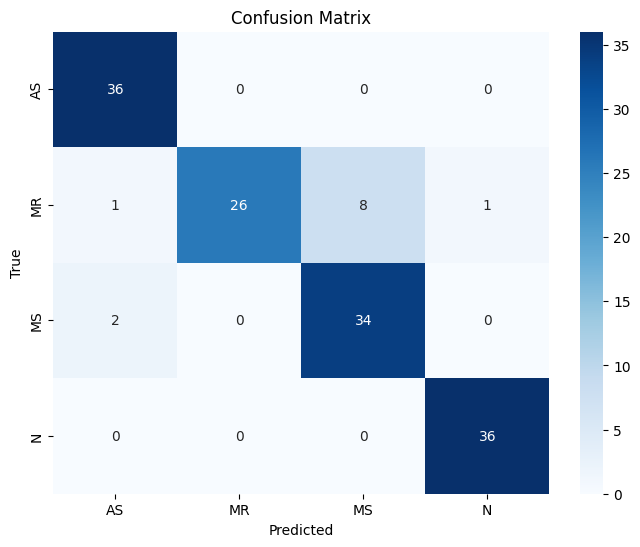

Skipping SMOTE: Only one class detected in y_train_spectrogram.
Skipping SMOTE: Only one class detected in y_train_mfcc.
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
Class Mapping in Label Encoder:
AS: 0
MR: 1
MS: 2
N: 3
MVP: 4
🔹 Combined X_train shape: (204, 13, 1)
🔹 Combined y_train shape: (204, 5)
🔵 Adding new label: Current num_classes = 4, Incrementing by 1.
✅ Old Weights Stored Successfully!
✅ Old Output Layer Weights Retrieved
✅ Created New Output Layer with 5 Classes
✅ Model Architecture Updated Successfully!
✅ New Output Layer Weights Set Successfully!
✅ Model Compiled Successfully!
🔄 Adjusted Labels: min=0, max=4
Epoch 1/30, Loss: 3.0720, Accuracy: 0.4663, Val_Loss: 0.7833, Val_Accuracy: 0.9024
Epoch 2/30, Loss: 2.3859, Accuracy: 0.4663, Val_Loss: 0.7555, Val_Accuracy: 0.9024
Epoch 3/30, Loss: 1.8719, Accuracy: 0.4785, Val_Loss: 0.7956, Val_Accuracy: 0.8780
Epoch 4/30, Loss: 1.5084, Accuracy: 0.5460, Val_Loss: 0.8432, Val_Accuracy: 0.8780
Epoch 5/30, Loss: 1.2605, Accur

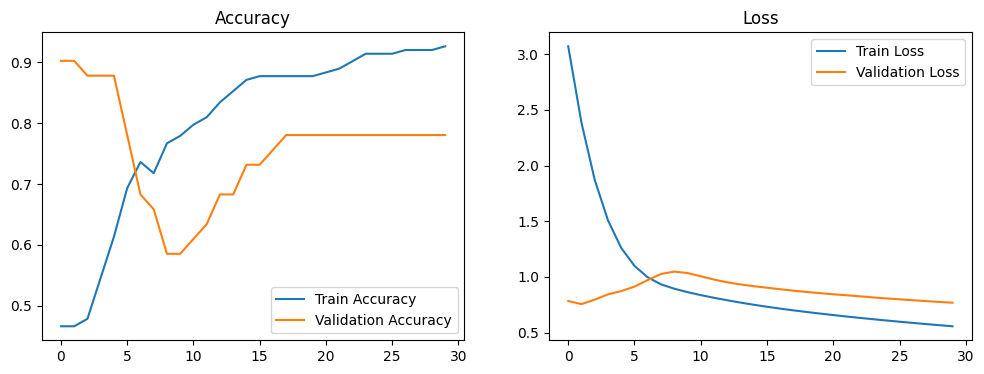

🚀 Incremental Training Complete!
[1. 0. 0. 0. 0.]
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

          AS       1.00      0.97      0.99        36
          MR       1.00      0.72      0.84        36
          MS       1.00      0.58      0.74        36
           N       1.00      0.97      0.99        36
         MVP       0.57      1.00      0.73        36

    accuracy                           0.85       180
   macro avg       0.91      0.85      0.85       180
weighted avg       0.91      0.85      0.85       180

CNN Test Accuracy: 0.85


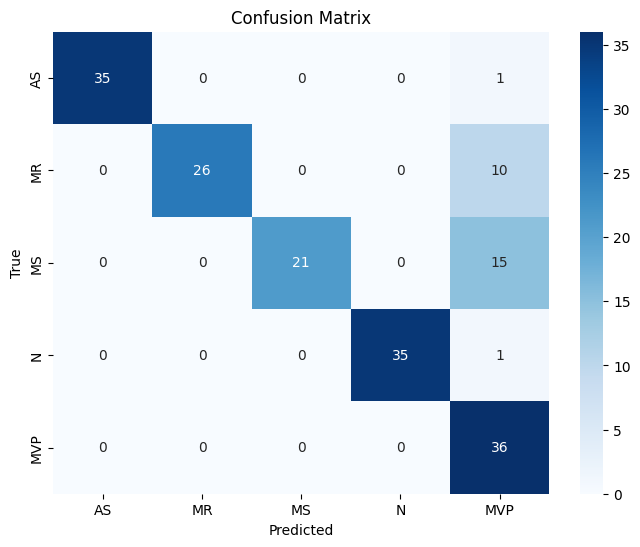

In [ ]:
import pickle

initial_csv_path  = r"..\Dataset\base_audio_mfcc_features_with_labels.csv"
X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, \
X_train_spectrogram, y_train_spectrogram, X_test_spectrogram, y_test_spectrogram, \
label_encoder, datagen = SplitDataset(initial_csv_path)
# Remove extra dimensions
X_train_mfcc = np.squeeze(X_train_mfcc)  # Remove extra dimensions
X_test_mfcc = np.squeeze(X_test_mfcc)

# Ensure it's in (batch, time_steps, features) format
if len(X_train_mfcc.shape) == 2:  # (batch, time_steps)
    X_train_mfcc = np.expand_dims(X_train_mfcc, axis=-1)  # (batch, time_steps, features)

if len(X_test_mfcc.shape) == 2:
    X_test_mfcc = np.expand_dims(X_test_mfcc, axis=-1)

print("Final X_train_mfcc shape:", X_train_mfcc.shape)  # Should be (336, 13, features)

# Ensure y_train_mfcc is correctly formatted
y_train_mfcc = np.argmax(y_train_mfcc, axis=1) if len(y_train_mfcc.shape) > 1 else y_train_mfcc

# Define model
input_shape = (X_train_mfcc.shape[1], X_train_mfcc.shape[2])  # (time_steps, features)
num_classes = np.max(y_train_mfcc) + 1

model = IncrementalCNN(input_shape, num_classes, l2_reg=0.0005)
model.train_initial(X_train_mfcc, y_train_mfcc)


model.evaluate_model(X_test_mfcc, np.argmax(y_test_mfcc, axis=1), label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

incremental_csv_path = r"..\Dataset\inc_audio_mfcc_features_with_labels.csv"

inc_train_x_mfcc, inc_train_y_mfcc, inc_test_mfcc, _, _, _, _, _, upd_label_encoder, _ = SplitDataset(incremental_csv_path, loaded_label_encoder)
print(upd_label_encoder.classes_)
model.train_incremental(inc_train_x_mfcc, np.argmax(inc_train_y_mfcc, axis=1), validation_split=0.2) #use incremental train function.
model.evaluate_model(X_test_mfcc, np.argmax(y_test_mfcc, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)

with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

mvp_csv_path = r"..\Dataset\continuous_audio_mfcc_features_with_labels.csv"
mvp_train_x_mfcc, mvp_train_y_mfcc, mvp_test_x_mfcc, mvp_test_y_mfcc, _, _, _, _, upd_label_encoder, _ = SplitDataset(mvp_csv_path, loaded_label_encoder)

def sample_data(X, y, sample_ratio=0.2):
    """Randomly selects a percentage of the data."""
    sample_size = int(len(X) * sample_ratio)  # Calculate 20% of the data
    indices = np.random.choice(len(X), sample_size, replace=False)  # Randomly select indices
    return X[indices], y[indices]  # Return sampled data

old_x_train_mfcc,old_y_train_mfcc,old_x_test_mfcc, old_y_test_mfcc, _,_,_,_,upd_label_encoder, _ = SplitDataset(initial_csv_path, upd_label_encoder)
print(old_y_train_mfcc[3])
old_x_sample, old_y_sample = sample_data(old_x_train_mfcc, old_y_train_mfcc, sample_ratio=0.2)

print(old_y_sample[3])
print(old_y_test_mfcc[12])

print("Class Mapping in Label Encoder:")
for class_name, encoded_value in zip(upd_label_encoder.classes_, range(len(upd_label_encoder.classes_))):
    print(f"{class_name}: {encoded_value}")

combined_x_train = np.concatenate((mvp_train_x_mfcc, old_x_sample), axis=0)
combined_y_train = np.concatenate((mvp_train_y_mfcc, old_y_sample), axis=0)

# Debug: Print shapes before training
print(f"🔹 Combined X_train shape: {combined_x_train.shape}")
print(f"🔹 Combined y_train shape: {combined_y_train.shape}")

# Use the combined dataset for incremental learning
model.add_new_label(combined_x_train, np.argmax(combined_y_train, axis=1)) 

# Ensure all arrays are NumPy arrays
print(old_y_test_mfcc[12])
X_combined_test = np.concatenate((old_x_test_mfcc, mvp_test_x_mfcc), axis=0)
y_combined_test = np.concatenate((old_y_test_mfcc, mvp_test_y_mfcc), axis=0)

# Evaluate the model with the combined test set
model.evaluate_model(X_combined_test, np.argmax(y_combined_test, axis=1), upd_label_encoder)

# model.evaluate_model(mvp_test_x_mfcc, np.argmax(mvp_test_y_mfcc, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)

# SPECTROGRAM


## RESNET

In [50]:
#new
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

def load_and_preprocess_mfcc(classCSVPath, label_encoder=None):
    """Loads and preprocesses MFCC data, optionally using an existing label_encoder."""
    mfcc_df = pd.read_csv(classCSVPath)

    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(mfcc_df["Label"]) #Fit the encoder with all the unique labels.
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])
    else:
        # Check for new classes and update the encoder if necessary
        new_classes = set(mfcc_df["Label"].unique()) - set(label_encoder.classes_)
        for new_class in new_classes:
            label_encoder.classes_ = np.append(label_encoder.classes_, new_class)
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])

    mfcc_features = mfcc_df.iloc[:, 3:].values
    labels = mfcc_df["Label"].values

    scaler = StandardScaler()
    mfcc_features = scaler.fit_transform(mfcc_features)
    mfcc_features = mfcc_features.reshape(mfcc_features.shape[0], mfcc_features.shape[1], 1)

    labels_one_hot = to_categorical(labels, num_classes=len(label_encoder.classes_))

    return mfcc_features, labels_one_hot, label_encoder


def load_and_preprocess_spectrogram(spectrogram_paths, label_encoder):
    """Loads and preprocesses spectrogram data."""

    def _load_spectrogram_image(path):  # Inner helper function
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
        corrected_path = os.path.abspath(os.path.join(BASE_DIR, path))
        if os.path.exists(corrected_path):
            img = load_img(corrected_path, target_size=(224, 224), color_mode='rgb')
            img = img_to_array(img) / 255.0
            return img, os.path.basename(os.path.dirname(corrected_path))
        else:
            print(f"Warning: Spectrogram not found at {corrected_path}")
            return None, None  # Or raise an exception if you prefer

    images = []
    labels = []
    for path in spectrogram_paths:
        img, label = _load_spectrogram_image(path)
        if img is not None:  # Check if image was loaded successfully
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = label_encoder.transform(labels) # Use the same LabelEncoder
    labels_one_hot = to_categorical(labels, num_classes=len(label_encoder.classes_))
    return images, labels_one_hot

def apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram, label_encoder):
    """Applies data augmentation and SMOTE to spectrogram data."""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train_spectrogram)  # Fit BEFORE SMOTE

    unique_classes = np.unique(np.argmax(y_train_spectrogram, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_spectrogram.reshape(X_train_spectrogram.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_spectrogram, axis=1))
        X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)  # Reshape back
        y_train_resampled = to_categorical(y_train_resampled, num_classes=len(label_encoder.classes_))
    else:
        print("Skipping SMOTE: Only one class detected in y_train_spectrogram.")
        X_train_resampled, y_train_resampled = X_train_spectrogram, y_train_spectrogram  # Use original data

    return X_train_resampled, y_train_resampled, datagen


def apply_smote_mfcc(X_train_mfcc, y_train_mfcc, label_encoder):
    """Applies SMOTE to MFCC data."""
    unique_classes = np.unique(np.argmax(y_train_mfcc, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_mfcc.reshape(X_train_mfcc.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_mfcc, axis=1))
        X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
        y_train_resampled = to_categorical(y_train_resampled, num_classes=len(label_encoder.classes_))
    else:
        print("Skipping SMOTE: Only one class detected in y_train_mfcc.")
        X_train_resampled, y_train_resampled = X_train_mfcc, y_train_mfcc  # Use original data

    return X_train_resampled, y_train_resampled


def SplitDataset(classCSVPath, label_encoder=None):
    """Main function to split and preprocess the dataset."""

    mfcc_features, y_mfcc, label_encoder = load_and_preprocess_mfcc(classCSVPath, label_encoder)
    spectrogram_paths = pd.read_csv(classCSVPath)["Spectrogram_Path"].values

    X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc, train_indices, test_indices = train_test_split(
        mfcc_features, y_mfcc, range(len(y_mfcc)), test_size=0.3, random_state=37, stratify = np.argmax(y_mfcc, axis=1) # Stratify based on original labels
    )

    X_train_spectrogram_paths = spectrogram_paths[train_indices]
    X_test_spectrogram_paths = spectrogram_paths[test_indices]

    X_train_spectrogram, y_train_spectrogram = load_and_preprocess_spectrogram(X_train_spectrogram_paths, label_encoder)
    X_test_spectrogram, y_test_spectrogram = load_and_preprocess_spectrogram(X_test_spectrogram_paths, label_encoder)


    X_train_spectrogram_resampled, y_train_spectrogram_resampled, datagen = apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram, label_encoder)
    X_train_mfcc_resampled, y_train_mfcc_resampled = apply_smote_mfcc(X_train_mfcc, y_train_mfcc, label_encoder)

    return X_train_mfcc_resampled, y_train_mfcc_resampled, X_test_mfcc, y_test_mfcc, \
           X_train_spectrogram_resampled, y_train_spectrogram_resampled, X_test_spectrogram, y_test_spectrogram, \
           label_encoder, datagen


In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2, ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

class IncrementalResNet:
    def __init__(self, input_shape, num_classes, learning_rate=0.0002, l2_reg=0.001): # Added l2_reg parameter
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg # Store the L2 regularization value
        self.model = self.build_model()
        self.fisher_matrix = None
        self.previous_weights = None
    


    def build_model(self):
        base_model = ResNet50V2(input_shape=self.input_shape, include_top=False, weights='imagenet')
        base_model.trainable = False  # Freeze the pre-trained layers

        x = layers.GlobalAveragePooling2D()(base_model.output)
        x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))(x)
        output_layer = layers.Dense(self.num_classes, activation='softmax')(x)

        model = models.Model(inputs=base_model.input, outputs=output_layer)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model


    def train_initial(self, X_train, y_train, epochs=10, batch_size=32, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = self.model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size,validation_split=validation_split, verbose=1,callbacks=[early_stopping])
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.previous_weights = self.model.get_weights()
        self.plot_training_history(history)
        print(self.fisher_matrix)
    
    def calculate_fisher_matrix(self, X_train, y_train_one_hot):
        fisher_matrices = [np.zeros_like(weight.numpy()) for weight in self.model.trainable_weights]

        for i in range(len(X_train)):
            with tf.GradientTape() as tape:
                predictions = self.model(np.expand_dims(X_train[i], axis=0))
                loss = losses.categorical_crossentropy(np.expand_dims(y_train_one_hot[i], axis=0), predictions)

            gradients = tape.gradient(loss, self.model.trainable_weights)
            for j, grad in enumerate(gradients):
                if grad is not None:  # Ensure grad is not None (e.g., for unused weights)
                    fisher_matrices[j] += np.square(grad.numpy())

        # Normalize Fisher matrix
        fisher_matrices = [fisher / len(X_train) for fisher in fisher_matrices]
        self.fisher_matrix = fisher_matrices


    def train_incremental(self, X_train, y_train, epochs=5, batch_size=32, ewc_lambda=7.0, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        optimizer = optimizers.Adam(learning_rate=self.learning_rate)

        # Split data for validation
        train_size = int(len(X_train) * (1 - validation_split))
        X_train_train, X_val = X_train[:train_size], X_train[train_size:]
        y_train_train, y_val = y_train_one_hot[:train_size], y_train_one_hot[train_size:]

        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(epochs):
            for batch_start in range(0, len(X_train_train), batch_size):
                batch_end = batch_start + batch_size
                batch_X = X_train_train[batch_start:batch_end]
                batch_y = y_train_train[batch_start:batch_end]

                with tf.GradientTape() as tape:
                    predictions = self.model(batch_X, training=True)
                    loss = losses.categorical_crossentropy(batch_y, predictions)

                    # EWC regularization
                    if self.fisher_matrix and self.previous_weights:
                        ewc_loss = 0.0
                        for i, weight in enumerate(self.model.trainable_weights):
                            # Skip output layer weights in EWC calculation
                            if weight.shape != self.previous_weights[i].shape:
                                continue
                            ewc_loss += ewc_lambda * tf.reduce_sum(self.fisher_matrix[i] * tf.square(weight - self.previous_weights[i]))
                        loss += ewc_loss

                gradients = tape.gradient(loss, self.model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

            # Evaluate on training and validation sets
            train_loss, train_acc = self.model.evaluate(X_train_train, y_train_train, verbose=0)
            val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)

            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc:.4f}")

        self.previous_weights = self.model.get_weights()
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.ewc_plot_training_history(history)
        # print("Changed fisher matrix: ", self.fisher_matrix)

    def add_new_label(self, X_train, y_train, X_old=None, y_old=None, epochs=5, batch_size=16, ewc_lambda=5.0):
        """Adds a new label to the model incrementally, updating the output layer."""
        
        print(f"🔵 Adding new label: Current num_classes = {self.num_classes}, Incrementing by 1.")
        self.num_classes += 1  # Increment class count

        # Store existing weights
        old_weights = {layer.name: layer.get_weights() for layer in self.model.layers}
        print("✅ Old Weights Stored Successfully!")

        # Retrieve old output layer weights
        old_output_layer = self.model.layers[-1]
        old_output_weights = old_output_layer.get_weights()
        # print(f"✅ Old Output Layer Weights Retrieved\nOld Output Layer Weights Shape: {[w.shape for w in old_output_weights]}")

        # Create a new output layer with one additional neuron
        new_output_layer = layers.Dense(self.num_classes, activation='softmax', 
                                        kernel_regularizer=regularizers.l2(self.l2_reg), 
                                        name='new_output_layer')
        print(f"✅ Created New Output Layer with {self.num_classes} Classes")
        
        # Replace the output layer
        x = self.model.layers[-2].output  # Get the previous layer output
        output_tensor = new_output_layer(x)  # Attach the new output layer
        self.model = models.Model(inputs=self.model.input, outputs=output_tensor)
        print("✅ Model Architecture Updated Successfully!")
        
        # Transfer weights to all layers except the output layer
        for layer in self.model.layers[:-1]:
            if layer.name in old_weights:
                layer.set_weights(old_weights[layer.name])
                # print(f"✅ Weights Transferred to Layer: {layer.name}")
        
        # Initialize the new output layer with old weights + random values for the new class
        new_output_weights = []
        for i, old_w in enumerate(old_output_weights):
            # print(f"🔍 Processing Old Weight {i}: Shape {old_w.shape}")
            
            if old_w.ndim == 2:  # Weight matrix
                new_w = np.concatenate([old_w, np.random.normal(0, 0.01, (old_w.shape[0], 1))], axis=1)
            elif old_w.ndim == 1:  # Bias vector
                new_w = np.concatenate([old_w, np.zeros((1,))], axis=0)
            else:
                print(f"🚨 Unexpected Shape in Weights: {old_w.shape}")
                return  # Stop execution if an error occurs
            
            # print(f"✅ New Weight {i} Shape: {new_w.shape}")
            new_output_weights.append(new_w)
        
        # print(f"🔍 Final New Output Weights Shape: {[w.shape for w in new_output_weights]}")
        
        # Set new weights for the output layer
        try:
            new_output_layer.set_weights(new_output_weights)
            print("✅ New Output Layer Weights Set Successfully!")
        except ValueError as e:
            print(f"🚨 Weight Assignment Error: {e}")
            return

        # Recompile model
        self.learning_rate = 0.00060
        self.model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                        loss=losses.CategoricalCrossentropy(),
                        metrics=['accuracy'])
        print("✅ Model Compiled Successfully!")
        
        # Adjust new labels
        y_train_adjusted = y_train + (self.num_classes - 1 - np.max(y_train))
        # print(f"🔄 Adjusted Labels: min={y_train_adjusted.min()}, max={y_train_adjusted.max()}")

        # Merge old and new data
        if X_old is not None and y_old is not None:
            X_combined = np.concatenate((X_train, X_old), axis=0)
            y_combined = np.concatenate((y_train_adjusted, y_old), axis=0)
            # print(f"✅ Combined Data: X shape {X_combined.shape}, y shape {y_combined.shape}")
        else:
            X_combined = X_train
            y_combined = y_train_adjusted
            # print(f"✅ Using Only New Data: X shape {X_combined.shape}, y shape {y_combined.shape}")

        # Train the model incrementally
        self.train_incremental(X_combined, y_combined, epochs, batch_size, ewc_lambda)
        print("🚀 Incremental Training Complete!")

    def plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()

    def evaluate_model(self, X_test, y_test, label_encoder): #updated function to accept label_encoder
        y_pred_probs = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        print(classification_report(y_test, y_pred, target_names=label_encoder.inverse_transform(np.unique(y_test))))
        print(f" ResNet Test Accuracy: {np.mean(y_pred == y_test)}")

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform(np.unique(y_test)), yticklabels=label_encoder.inverse_transform(np.unique(y_test)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def ewc_plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()


In [52]:

import pickle

initial_csv_path  = r"..\Dataset\base_audio_mfcc_features_with_labels.csv"
X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, \
X_train_spectrogram, y_train_spectrogram, X_test_spectrogram, y_test_spectrogram, \
label_encoder, datagen = SplitDataset(initial_csv_path)

(224, 224, 3)
4
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3508 - loss: 1.7108 - val_accuracy: 0.7059 - val_loss: 1.2137
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8058 - loss: 1.0587 - val_accuracy: 0.8529 - val_loss: 0.9094
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9195 - loss: 0.7570 - val_accuracy: 0.9118 - val_loss: 0.6975
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9709 - loss: 0.5870 - val_accuracy: 0.9559 - val_loss: 0.5811
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9828 - loss: 0.4877 - val_accuracy: 0.9412 - val_loss: 0.5142
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9658 - loss: 0.4218 - val_accuracy: 0.9853 - val_loss: 0.4289
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9863 - loss: 0.3692 - val_accuracy: 0.9853 - val_loss: 0.4170
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9923 - loss: 0.3270 - val_accuracy: 0.9706 - val_loss:

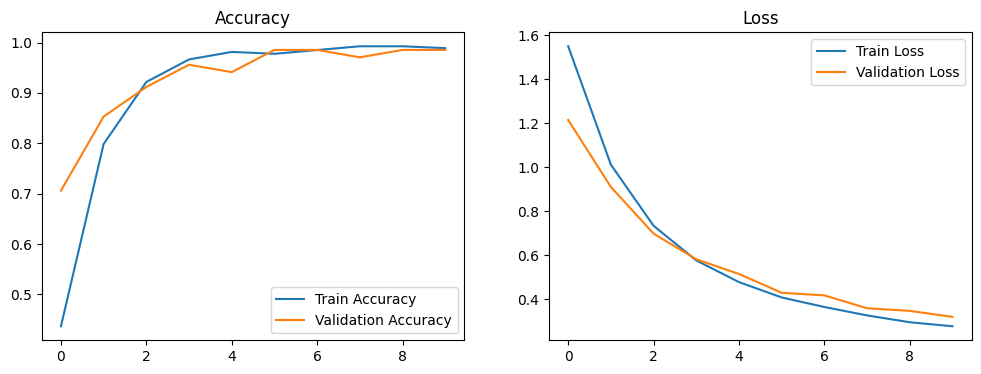

[array([[0.00000000e+00, 1.48705075e-08, 2.91117832e-08, ...,
        3.47173135e-08, 2.44278375e-08, 4.27086349e-08],
       [0.00000000e+00, 6.96594441e-07, 1.80364634e-06, ...,
        6.20943922e-07, 1.44843375e-06, 8.87621070e-07],
       [0.00000000e+00, 1.34837255e-03, 5.51661942e-03, ...,
        2.32442957e-03, 2.88996799e-03, 4.34233248e-03],
       ...,
       [0.00000000e+00, 2.78218322e-05, 1.83300235e-05, ...,
        2.84692724e-05, 2.79486849e-05, 3.43489410e-05],
       [0.00000000e+00, 1.11704076e-05, 7.98545429e-04, ...,
        1.01100268e-04, 3.74270690e-04, 2.01210292e-04],
       [0.00000000e+00, 4.77782081e-08, 3.60971995e-07, ...,
        6.83202614e-08, 1.84687423e-07, 1.00192565e-07]], dtype=float32), array([0.00000000e+00, 1.24036218e-04, 5.39911736e-04, 1.06289226e-04,
       0.00000000e+00, 3.32412223e-04, 0.00000000e+00, 0.00000000e+00,
       5.03865595e-04, 1.18463002e-04, 2.07466102e-04, 3.68620764e-04,
       0.00000000e+00, 2.05578744e-05, 3.48737049

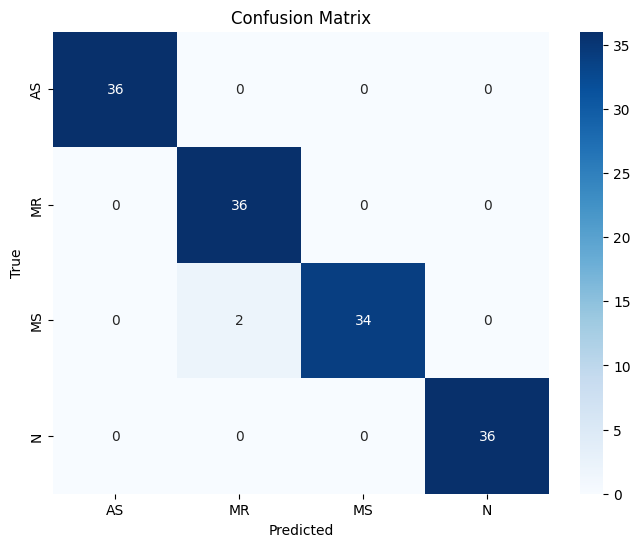

In [53]:
input_shape = (X_train_spectrogram.shape[1], X_train_spectrogram.shape[1],3)  # (time_steps, features)
num_classes = y_train_spectrogram.shape[1]
print(input_shape)
print(num_classes)

model = IncrementalResNet(input_shape, num_classes,l2_reg=0.0005)
model.train_initial(X_train_spectrogram, np.argmax(y_train_spectrogram, axis=1))
model.evaluate_model(X_test_spectrogram, np.argmax(y_test_spectrogram, axis=1), label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)




Epoch 1/5, Loss: 0.4172, Accuracy: 0.9385, Val_Loss: 0.5332, Val_Accuracy: 0.9111
Epoch 2/5, Loss: 0.3622, Accuracy: 0.9330, Val_Loss: 0.4347, Val_Accuracy: 0.8667
Epoch 3/5, Loss: 0.3205, Accuracy: 0.9665, Val_Loss: 0.4286, Val_Accuracy: 0.8889
Epoch 4/5, Loss: 0.2833, Accuracy: 0.9721, Val_Loss: 0.3389, Val_Accuracy: 0.9333
Epoch 5/5, Loss: 0.2592, Accuracy: 0.9777, Val_Loss: 0.3320, Val_Accuracy: 0.9111


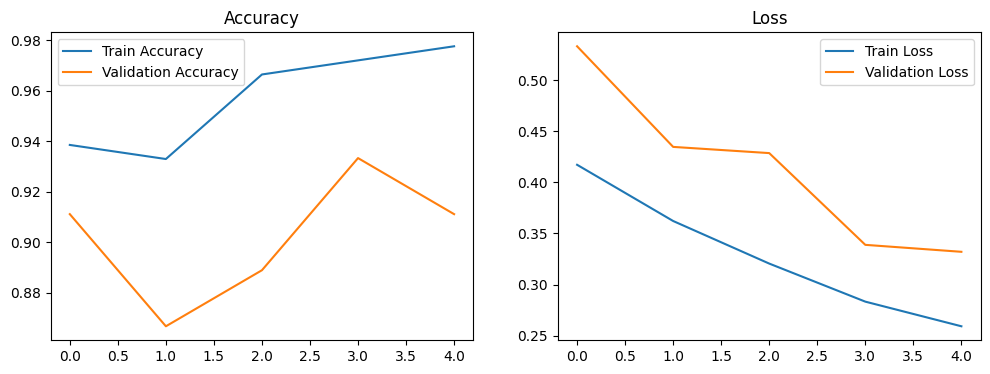

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
              precision    recall  f1-score   support

          AS       1.00      1.00      1.00        24
          MR       1.00      1.00      1.00        24
          MS       1.00      1.00      1.00        24
           N       1.00      1.00      1.00        24

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

 ResNet Test Accuracy: 1.0


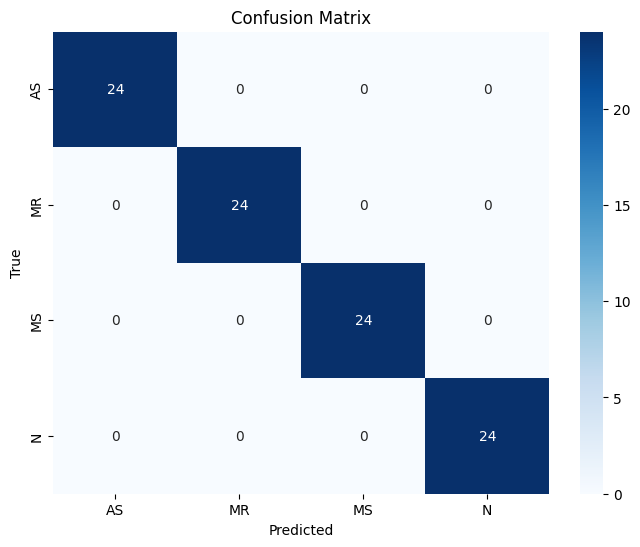

In [54]:
with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

incremental_csv_path = r"..\Dataset\inc_audio_mfcc_features_with_labels.csv"

inc_train_x_mfcc, inc_train_y_mfcc, inc_test_x_mfcc, inc_test_y_mfcc, \
inc_train_x_spectrogram, inc_train_y_spectrogram, inc_test_x_spectrogram, inc_test_y_spectrogram, \
upd_label_encoder, datagen = SplitDataset(incremental_csv_path, loaded_label_encoder)

# print(upd_label_encoder.classes_)

model.train_incremental(inc_train_x_spectrogram, np.argmax(inc_train_y_spectrogram, axis=1), validation_split=0.2)
model.evaluate_model(inc_test_x_spectrogram, np.argmax(inc_test_y_spectrogram, axis=1), upd_label_encoder)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)

Skipping SMOTE: Only one class detected in y_train_spectrogram.
Skipping SMOTE: Only one class detected in y_train_mfcc.
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
Class Mapping in Label Encoder:
AS: 0
MR: 1
MS: 2
N: 3
MVP: 4
🔹 Combined X_train shape: (184, 224, 224, 3)
🔹 Combined y_train shape: (184, 5)
🔵 Adding new label: Current num_classes = 4, Incrementing by 1.
✅ Old Weights Stored Successfully!
✅ Created New Output Layer with 5 Classes
✅ Model Architecture Updated Successfully!
✅ New Output Layer Weights Set Successfully!
✅ Model Compiled Successfully!
Epoch 1/5, Loss: 0.7962, Accuracy: 0.7279, Val_Loss: 1.8027, Val_Accuracy: 0.3514
Epoch 2/5, Loss: 0.5088, Accuracy: 0.9252, Val_Loss: 0.4745, Val_Accuracy: 0.9189
Epoch 3/5, Loss: 0.3793, Accuracy: 0.9660, Val_Loss: 0.6733, Val_Accuracy: 0.7838
Epoch 4/5, Loss: 0.3056, Accuracy: 0.9864, Val_Loss: 0.5095, Val_Accuracy: 0.8649
Epoch 5/5, Loss: 0.2708, Accuracy: 0.9932, Val_Loss: 0.5110, Val_Accuracy: 0.8378


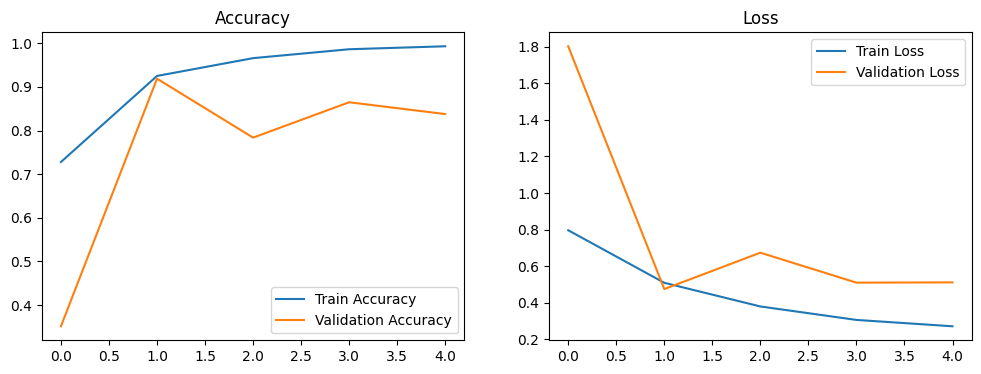

🚀 Incremental Training Complete!
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
              precision    recall  f1-score   support

          AS       0.90      0.75      0.82        36
          MR       0.96      0.72      0.83        36
          MS       1.00      0.92      0.96        36
           N       1.00      1.00      1.00        36
         MVP       0.67      1.00      0.80        36

    accuracy                           0.88       180
   macro avg       0.91      0.88      0.88       180
weighted avg       0.91      0.88      0.88       180

 ResNet Test Accuracy: 0.8777777777777778


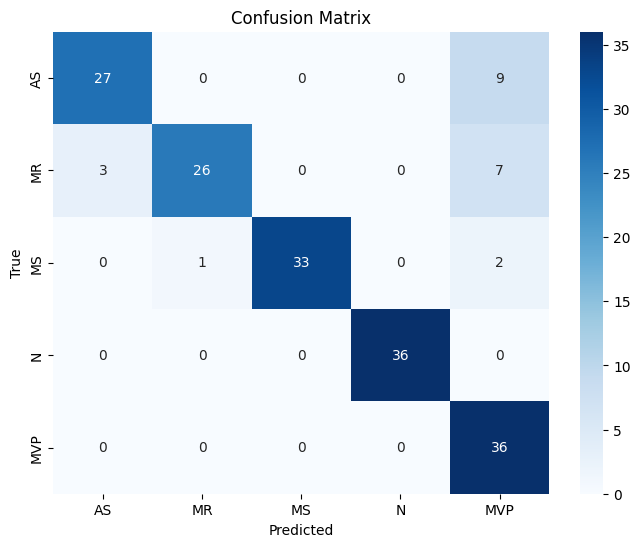

In [ ]:

import pickle
import numpy as np

with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

mvp_csv_path = r"..\Dataset\continuous_audio_mfcc_features_with_labels.csv"

mvp_train_x_mfcc, mvp_train_y_mfcc, mvp_test_x_mfcc, mvp_test_y_mfcc, \
mvp_train_x_spectrogram, mvp_train_y_spectrogram, mvp_test_x_spectrogram, mvp_test_y_spectrogram, \
upd_label_encoder, _ = SplitDataset(mvp_csv_path, loaded_label_encoder)

# Function to sample data
def sample_data(X, y, sample_ratio=0.2):
    """Randomly selects a percentage of the data."""
    sample_size = int(len(X) * sample_ratio)
    indices = np.random.choice(len(X), sample_size, replace=False)
    return X[indices], y[indices]

old_x_train_mfcc, old_y_train_mfcc, old_x_test_mfcc, old_y_test_mfcc, \
old_x_train_spectrogram, old_y_train_spectrogram, old_x_test_spectrogram, old_y_test_spectrogram, \
upd_label_encoder, _ = SplitDataset(initial_csv_path, upd_label_encoder)

# Sample data from the old dataset
old_x_sample, old_y_sample = sample_data(old_x_train_spectrogram, old_y_train_spectrogram, sample_ratio=0.2)


print(old_y_train_spectrogram[3])
print(old_y_sample[3])
print(old_y_test_spectrogram[12])

print("Class Mapping in Label Encoder:")
for class_name, encoded_value in zip(upd_label_encoder.classes_, range(len(upd_label_encoder.classes_))):
    print(f"{class_name}: {encoded_value}")

combined_x_train = np.concatenate((mvp_train_x_spectrogram, old_x_sample), axis=0)
combined_y_train = np.concatenate((mvp_train_y_spectrogram, old_y_sample), axis=0)

print(f"🔹 Combined X_train shape: {combined_x_train.shape}")
print(f"🔹 Combined y_train shape: {combined_y_train.shape}")

model.add_new_label(combined_x_train, np.argmax(combined_y_train, axis=1))

X_combined_test = np.concatenate((old_x_test_spectrogram, mvp_test_x_spectrogram), axis=0)
y_combined_test = np.concatenate((old_y_test_spectrogram, mvp_test_y_spectrogram), axis=0)

model.evaluate_model(X_combined_test, np.argmax(y_combined_test, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)


## MOBILENET

In [56]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

def load_and_preprocess_mfcc(classCSVPath, label_encoder=None):
    """Loads and preprocesses MFCC data, optionally using an existing label_encoder."""
    mfcc_df = pd.read_csv(classCSVPath)

    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(mfcc_df["Label"]) #Fit the encoder with all the unique labels.
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])
    else:
        # Check for new classes and update the encoder if necessary
        new_classes = set(mfcc_df["Label"].unique()) - set(label_encoder.classes_)
        for new_class in new_classes:
            label_encoder.classes_ = np.append(label_encoder.classes_, new_class)
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])

    mfcc_features = mfcc_df.iloc[:, 3:].values
    labels = mfcc_df["Label"].values

    scaler = StandardScaler()
    mfcc_features = scaler.fit_transform(mfcc_features)
    mfcc_features = mfcc_features.reshape(mfcc_features.shape[0], mfcc_features.shape[1], 1)

    labels_one_hot = to_categorical(labels, num_classes=len(label_encoder.classes_))

    return mfcc_features, labels_one_hot, label_encoder


def load_and_preprocess_spectrogram(spectrogram_paths, label_encoder):
    """Loads and preprocesses spectrogram data."""

    def _load_spectrogram_image(path):  # Inner helper function
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
        corrected_path = os.path.abspath(os.path.join(BASE_DIR, path))
        if os.path.exists(corrected_path):
            img = load_img(corrected_path, target_size=(224, 224), color_mode='rgb')
            img = img_to_array(img) / 255.0
            return img, os.path.basename(os.path.dirname(corrected_path))
        else:
            print(f"Warning: Spectrogram not found at {corrected_path}")
            return None, None  # Or raise an exception if you prefer

    images = []
    labels = []
    for path in spectrogram_paths:
        img, label = _load_spectrogram_image(path)
        if img is not None:  # Check if image was loaded successfully
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = label_encoder.transform(labels) # Use the same LabelEncoder
    labels_one_hot = to_categorical(labels, num_classes=len(label_encoder.classes_))
    return images, labels_one_hot

def apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram, label_encoder):
    """Applies data augmentation and SMOTE to spectrogram data."""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train_spectrogram)  # Fit BEFORE SMOTE

    unique_classes = np.unique(np.argmax(y_train_spectrogram, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_spectrogram.reshape(X_train_spectrogram.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_spectrogram, axis=1))
        X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)  # Reshape back
        y_train_resampled = to_categorical(y_train_resampled, num_classes=len(label_encoder.classes_))
    else:
        print("Skipping SMOTE: Only one class detected in y_train_spectrogram.")
        X_train_resampled, y_train_resampled = X_train_spectrogram, y_train_spectrogram  # Use original data

    return X_train_resampled, y_train_resampled, datagen


def apply_smote_mfcc(X_train_mfcc, y_train_mfcc, label_encoder):
    """Applies SMOTE to MFCC data."""
    unique_classes = np.unique(np.argmax(y_train_mfcc, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_mfcc.reshape(X_train_mfcc.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_mfcc, axis=1))
        X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
        y_train_resampled = to_categorical(y_train_resampled, num_classes=len(label_encoder.classes_))
    else:
        print("Skipping SMOTE: Only one class detected in y_train_mfcc.")
        X_train_resampled, y_train_resampled = X_train_mfcc, y_train_mfcc  # Use original data

    return X_train_resampled, y_train_resampled


def SplitDataset(classCSVPath, label_encoder=None):
    """Main function to split and preprocess the dataset."""

    mfcc_features, y_mfcc, label_encoder = load_and_preprocess_mfcc(classCSVPath, label_encoder)
    spectrogram_paths = pd.read_csv(classCSVPath)["Spectrogram_Path"].values

    X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc, train_indices, test_indices = train_test_split(
        mfcc_features, y_mfcc, range(len(y_mfcc)), test_size=0.3, random_state=37, stratify = np.argmax(y_mfcc, axis=1) # Stratify based on original labels
    )

    X_train_spectrogram_paths = spectrogram_paths[train_indices]
    X_test_spectrogram_paths = spectrogram_paths[test_indices]

    X_train_spectrogram, y_train_spectrogram = load_and_preprocess_spectrogram(X_train_spectrogram_paths, label_encoder)
    X_test_spectrogram, y_test_spectrogram = load_and_preprocess_spectrogram(X_test_spectrogram_paths, label_encoder)


    X_train_spectrogram_resampled, y_train_spectrogram_resampled, datagen = apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram, label_encoder)
    X_train_mfcc_resampled, y_train_mfcc_resampled = apply_smote_mfcc(X_train_mfcc, y_train_mfcc, label_encoder)

    return X_train_mfcc_resampled, y_train_mfcc_resampled, X_test_mfcc, y_test_mfcc, \
           X_train_spectrogram_resampled, y_train_spectrogram_resampled, X_test_spectrogram, y_test_spectrogram, \
           label_encoder, datagen


In [57]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

class IncrementalMobileNet:
    def __init__(self, input_shape, num_classes, learning_rate=0.0002, l2_reg=0.001): # Added l2_reg parameter
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg # Store the L2 regularization value
        self.model = self.build_model()
        self.fisher_matrix = None
        self.previous_weights = None
    


    def build_model(self):
        base_model = MobileNetV2(input_shape=self.input_shape, include_top=False, weights='imagenet')
        base_model.trainable = False  # Freeze the pre-trained layers

        x = layers.GlobalAveragePooling2D()(base_model.output)
        x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))(x)
        output_layer = layers.Dense(self.num_classes, activation='softmax')(x)

        model = models.Model(inputs=base_model.input, outputs=output_layer)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model


    def train_initial(self, X_train, y_train, epochs=10, batch_size=32, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = self.model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size,validation_split=validation_split, verbose=1,callbacks=[early_stopping])
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.previous_weights = self.model.get_weights()
        self.plot_training_history(history)
        print(self.fisher_matrix)
    
    def calculate_fisher_matrix(self, X_train, y_train_one_hot):
        fisher_matrices = [np.zeros_like(weight.numpy()) for weight in self.model.trainable_weights]

        for i in range(len(X_train)):
            with tf.GradientTape() as tape:
                predictions = self.model(np.expand_dims(X_train[i], axis=0))
                loss = losses.categorical_crossentropy(np.expand_dims(y_train_one_hot[i], axis=0), predictions)

            gradients = tape.gradient(loss, self.model.trainable_weights)
            for j, grad in enumerate(gradients):
                if grad is not None:  # Ensure grad is not None (e.g., for unused weights)
                    fisher_matrices[j] += np.square(grad.numpy())

        # Normalize Fisher matrix
        fisher_matrices = [fisher / len(X_train) for fisher in fisher_matrices]
        self.fisher_matrix = fisher_matrices


    def train_incremental(self, X_train, y_train, epochs=5, batch_size=32, ewc_lambda=7.0, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        optimizer = optimizers.Adam(learning_rate=self.learning_rate)

        # Split data for validation
        train_size = int(len(X_train) * (1 - validation_split))
        X_train_train, X_val = X_train[:train_size], X_train[train_size:]
        y_train_train, y_val = y_train_one_hot[:train_size], y_train_one_hot[train_size:]

        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(epochs):
            for batch_start in range(0, len(X_train_train), batch_size):
                batch_end = batch_start + batch_size
                batch_X = X_train_train[batch_start:batch_end]
                batch_y = y_train_train[batch_start:batch_end]

                with tf.GradientTape() as tape:
                    predictions = self.model(batch_X, training=True)
                    loss = losses.categorical_crossentropy(batch_y, predictions)

                    # EWC regularization
                    if self.fisher_matrix and self.previous_weights:
                        ewc_loss = 0.0
                        for i, weight in enumerate(self.model.trainable_weights):
                            # Skip output layer weights in EWC calculation
                            if weight.shape != self.previous_weights[i].shape:
                                continue
                            ewc_loss += ewc_lambda * tf.reduce_sum(self.fisher_matrix[i] * tf.square(weight - self.previous_weights[i]))
                        loss += ewc_loss

                gradients = tape.gradient(loss, self.model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

            # Evaluate on training and validation sets
            train_loss, train_acc = self.model.evaluate(X_train_train, y_train_train, verbose=0)
            val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)

            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc:.4f}")

        self.previous_weights = self.model.get_weights()
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.ewc_plot_training_history(history)
        # print("Changed fisher matrix: ", self.fisher_matrix)

    def add_new_label(self, X_train, y_train, X_old=None, y_old=None, epochs=5, batch_size=16, ewc_lambda=5.0):
        """Adds a new label to the model incrementally, updating the output layer."""
        
        print(f"🔵 Adding new label: Current num_classes = {self.num_classes}, Incrementing by 1.")
        self.num_classes += 1  # Increment class count

        # Store existing weights
        old_weights = {layer.name: layer.get_weights() for layer in self.model.layers}
        print("✅ Old Weights Stored Successfully!")

        # Retrieve old output layer weights
        old_output_layer = self.model.layers[-1]
        old_output_weights = old_output_layer.get_weights()
        # print(f"✅ Old Output Layer Weights Retrieved\nOld Output Layer Weights Shape: {[w.shape for w in old_output_weights]}")

        # Create a new output layer with one additional neuron
        new_output_layer = layers.Dense(self.num_classes, activation='softmax', 
                                        kernel_regularizer=regularizers.l2(self.l2_reg), 
                                        name='new_output_layer')
        print(f"✅ Created New Output Layer with {self.num_classes} Classes")
        
        # Replace the output layer
        x = self.model.layers[-2].output  # Get the previous layer output
        output_tensor = new_output_layer(x)  # Attach the new output layer
        self.model = models.Model(inputs=self.model.input, outputs=output_tensor)
        print("✅ Model Architecture Updated Successfully!")
        
        # Transfer weights to all layers except the output layer
        for layer in self.model.layers[:-1]:
            if layer.name in old_weights:
                layer.set_weights(old_weights[layer.name])
                print(f"✅ Weights Transferred to Layer: {layer.name}")
        
        # Initialize the new output layer with old weights + random values for the new class
        new_output_weights = []
        for i, old_w in enumerate(old_output_weights):
            # print(f"🔍 Processing Old Weight {i}: Shape {old_w.shape}")
            
            if old_w.ndim == 2:  # Weight matrix
                new_w = np.concatenate([old_w, np.random.normal(0, 0.01, (old_w.shape[0], 1))], axis=1)
            elif old_w.ndim == 1:  # Bias vector
                new_w = np.concatenate([old_w, np.zeros((1,))], axis=0)
            else:
                print(f"🚨 Unexpected Shape in Weights: {old_w.shape}")
                return  # Stop execution if an error occurs
            
            # print(f"✅ New Weight {i} Shape: {new_w.shape}")
            new_output_weights.append(new_w)
        
        # print(f"🔍 Final New Output Weights Shape: {[w.shape for w in new_output_weights]}")
        
        # Set new weights for the output layer
        try:
            new_output_layer.set_weights(new_output_weights)
            print("✅ New Output Layer Weights Set Successfully!")
        except ValueError as e:
            print(f"🚨 Weight Assignment Error: {e}")
            return

        # Recompile model
        self.learning_rate = 0.00035
        self.model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                        loss=losses.CategoricalCrossentropy(),
                        metrics=['accuracy'])
        print("✅ Model Compiled Successfully!")
        
        # Adjust new labels
        y_train_adjusted = y_train + (self.num_classes - 1 - np.max(y_train))
        # print(f"🔄 Adjusted Labels: min={y_train_adjusted.min()}, max={y_train_adjusted.max()}")

        # Merge old and new data
        if X_old is not None and y_old is not None:
            X_combined = np.concatenate((X_train, X_old), axis=0)
            y_combined = np.concatenate((y_train_adjusted, y_old), axis=0)
            # print(f"✅ Combined Data: X shape {X_combined.shape}, y shape {y_combined.shape}")
        else:
            X_combined = X_train
            y_combined = y_train_adjusted
            # print(f"✅ Using Only New Data: X shape {X_combined.shape}, y shape {y_combined.shape}")

        # Train the model incrementally
        self.train_incremental(X_combined, y_combined, epochs, batch_size, ewc_lambda)
        print("🚀 Incremental Training Complete!")

    def plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()

    def evaluate_model(self, X_test, y_test, label_encoder): #updated function to accept label_encoder
        y_pred_probs = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        print(classification_report(y_test, y_pred, target_names=label_encoder.inverse_transform(np.unique(y_test))))
        print(f"MobileNet Test Accuracy: {np.mean(y_pred == y_test)}")

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform(np.unique(y_test)), yticklabels=label_encoder.inverse_transform(np.unique(y_test)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def ewc_plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()


In [58]:
import pickle

initial_csv_path  = r"..\Dataset\base_audio_mfcc_features_with_labels.csv"
X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, \
X_train_spectrogram, y_train_spectrogram, X_test_spectrogram, y_test_spectrogram, \
label_encoder, datagen = SplitDataset(initial_csv_path)

(224, 224, 3)
4
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 718ms/step - accuracy: 0.3938 - loss: 1.7212 - val_accuracy: 0.6176 - val_loss: 1.1860
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 697ms/step - accuracy: 0.7543 - loss: 1.0140 - val_accuracy: 0.8529 - val_loss: 0.8705
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 769ms/step - accuracy: 0.9277 - loss: 0.7054 - val_accuracy: 0.9118 - val_loss: 0.6426
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 771ms/step - accuracy: 0.9472 - loss: 0.5724 - val_accuracy: 0.8824 - val_loss: 0.5761
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 716ms/step - accuracy: 0.9356 - loss: 0.4875 - val_accuracy: 0.9706 - val_loss: 0.4629
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 806ms/step - accuracy: 0.9909 - loss: 0.4064 - val_accuracy: 0.9412 - val_loss: 0.4330
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 697ms/step - accuracy: 0.9873 - loss: 0.3724 - val_accuracy: 0.9706 - val_loss: 0.3742
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 749ms/step - accuracy: 0.9812 - loss: 0.3285 - val_accuracy: 0.

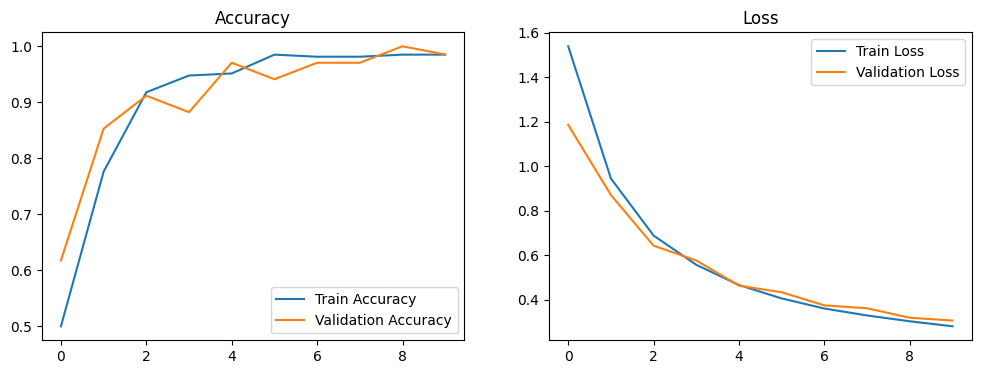

[array([[0.0000000e+00, 2.1510543e-06, 0.0000000e+00, ..., 2.9477621e-06,
        6.8261716e-06, 2.4732322e-05],
       [0.0000000e+00, 7.8596368e-06, 0.0000000e+00, ..., 5.8473461e-06,
        1.2079521e-05, 7.0695227e-05],
       [0.0000000e+00, 1.0161580e-06, 0.0000000e+00, ..., 1.5314987e-06,
        4.0431578e-06, 7.1649633e-06],
       ...,
       [0.0000000e+00, 5.8499104e-08, 0.0000000e+00, ..., 1.6688027e-08,
        1.4814111e-07, 3.0352217e-07],
       [0.0000000e+00, 5.8346308e-07, 0.0000000e+00, ..., 3.6261233e-07,
        2.8107959e-07, 2.7128870e-06],
       [0.0000000e+00, 1.1689924e-05, 0.0000000e+00, ..., 1.6387909e-05,
        4.2855187e-05, 2.0636377e-04]], dtype=float32), array([0.00000000e+00, 4.47870152e-05, 0.00000000e+00, 0.00000000e+00,
       1.12032535e-06, 4.69032166e-05, 0.00000000e+00, 4.12911351e-04,
       5.48233515e-07, 1.84241479e-04, 2.36154228e-04, 1.23189471e-04,
       1.19365730e-04, 3.65903048e-04, 0.00000000e+00, 4.59842122e-04,
       7.40189

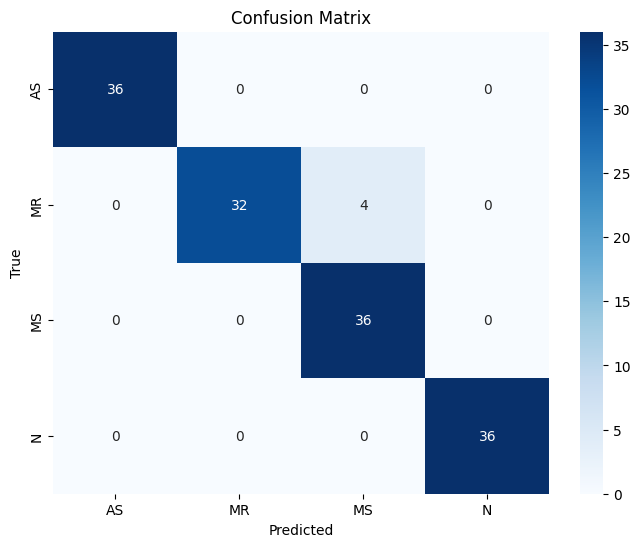

In [59]:
input_shape = (X_train_spectrogram.shape[1], X_train_spectrogram.shape[1],3)  # (time_steps, features)
num_classes = y_train_spectrogram.shape[1]
print(input_shape)
print(num_classes)

model = IncrementalMobileNet(input_shape, num_classes,l2_reg=0.0005)
model.train_initial(X_train_spectrogram, np.argmax(y_train_spectrogram, axis=1))
model.evaluate_model(X_test_spectrogram, np.argmax(y_test_spectrogram, axis=1), label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)




Epoch 1/5, Loss: 0.3632, Accuracy: 0.9553, Val_Loss: 0.5489, Val_Accuracy: 0.8889
Epoch 2/5, Loss: 0.3098, Accuracy: 0.9553, Val_Loss: 0.4698, Val_Accuracy: 0.8889
Epoch 3/5, Loss: 0.2788, Accuracy: 0.9888, Val_Loss: 0.3851, Val_Accuracy: 0.8889
Epoch 4/5, Loss: 0.2558, Accuracy: 0.9777, Val_Loss: 0.3606, Val_Accuracy: 0.9111
Epoch 5/5, Loss: 0.2382, Accuracy: 1.0000, Val_Loss: 0.3034, Val_Accuracy: 1.0000


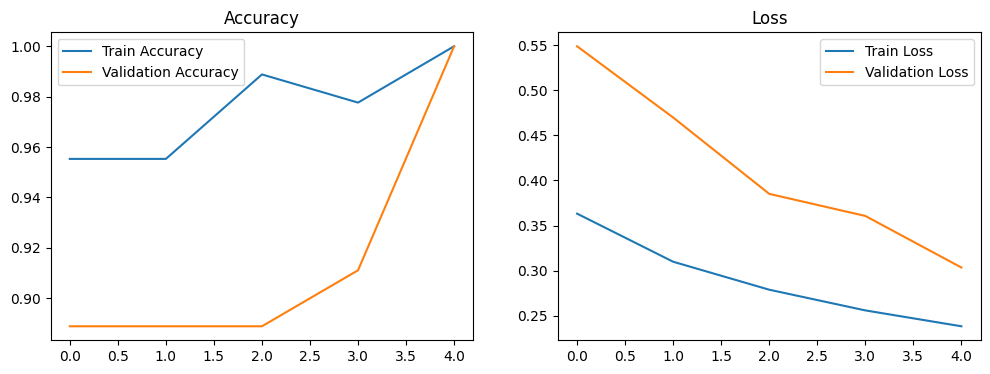

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step
              precision    recall  f1-score   support

          AS       1.00      0.96      0.98        24
          MR       0.96      0.96      0.96        24
          MS       1.00      1.00      1.00        24
           N       0.96      1.00      0.98        24

    accuracy                           0.98        96
   macro avg       0.98      0.98      0.98        96
weighted avg       0.98      0.98      0.98        96

MobileNet Test Accuracy: 0.9791666666666666


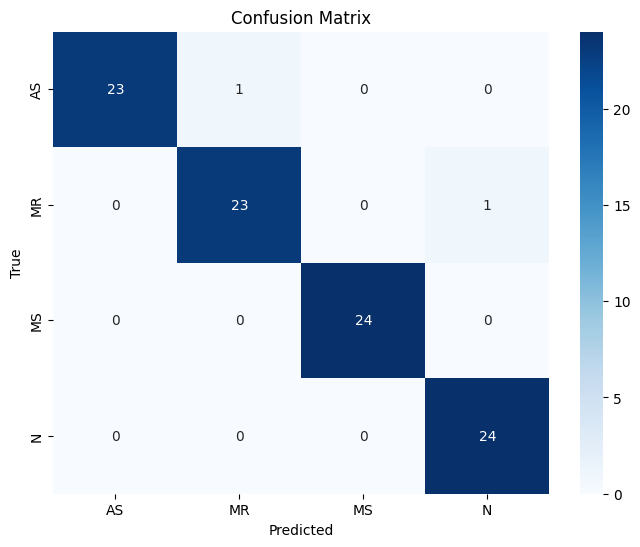

In [60]:
with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

incremental_csv_path = r"..\Dataset\inc_audio_mfcc_features_with_labels.csv"

inc_train_x_mfcc, inc_train_y_mfcc, inc_test_x_mfcc, inc_test_y_mfcc, \
inc_train_x_spectrogram, inc_train_y_spectrogram, inc_test_x_spectrogram, inc_test_y_spectrogram, \
upd_label_encoder, datagen = SplitDataset(incremental_csv_path, loaded_label_encoder)

# print(upd_label_encoder.classes_)

model.train_incremental(inc_train_x_spectrogram, np.argmax(inc_train_y_spectrogram, axis=1), validation_split=0.2)
model.evaluate_model(inc_test_x_spectrogram, np.argmax(inc_test_y_spectrogram, axis=1), upd_label_encoder)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)

Skipping SMOTE: Only one class detected in y_train_spectrogram.
Skipping SMOTE: Only one class detected in y_train_mfcc.
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
Class Mapping in Label Encoder:
AS: 0
MR: 1
MS: 2
N: 3
MVP: 4
🔹 Combined X_train shape: (151, 224, 224, 3)
🔹 Combined y_train shape: (151, 5)
🔵 Adding new label: Current num_classes = 4, Incrementing by 1.
✅ Old Weights Stored Successfully!
✅ Created New Output Layer with 5 Classes
✅ Model Architecture Updated Successfully!
✅ Weights Transferred to Layer: input_layer_13
✅ Weights Transferred to Layer: Conv1
✅ Weights Transferred to Layer: bn_Conv1
✅ Weights Transferred to Layer: Conv1_relu
✅ Weights Transferred to Layer: expanded_conv_depthwise
✅ Weights Transferred to Layer: expanded_conv_depthwise_BN
✅ Weights Transferred to Layer: expanded_conv_depthwise_relu
✅ Weights Transferred to Layer: expanded_conv_project
✅ Weights Transferred to Layer: expanded_conv_project_BN
✅ Weights Transferred to Layer: block_1_expand

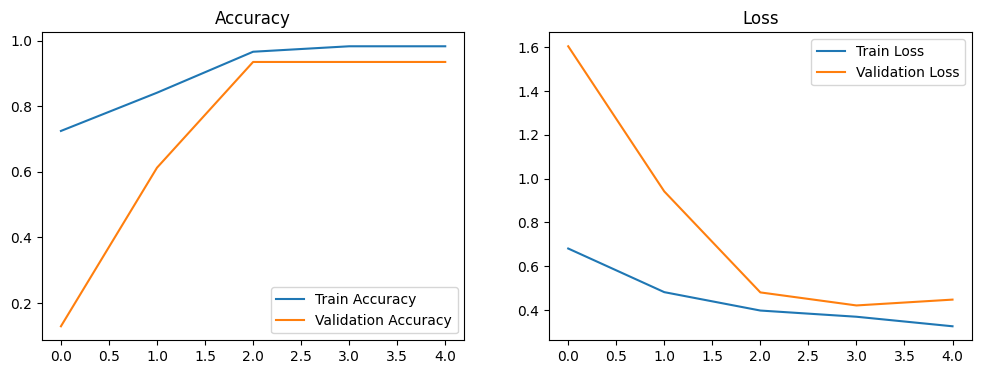

🚀 Incremental Training Complete!
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 636ms/step
              precision    recall  f1-score   support

          AS       0.88      1.00      0.94        36
          MR       1.00      0.78      0.88        36
          MS       1.00      0.89      0.94        36
           N       1.00      0.97      0.99        36
         MVP       0.82      1.00      0.90        36

    accuracy                           0.93       180
   macro avg       0.94      0.93      0.93       180
weighted avg       0.94      0.93      0.93       180

MobileNet Test Accuracy: 0.9277777777777778


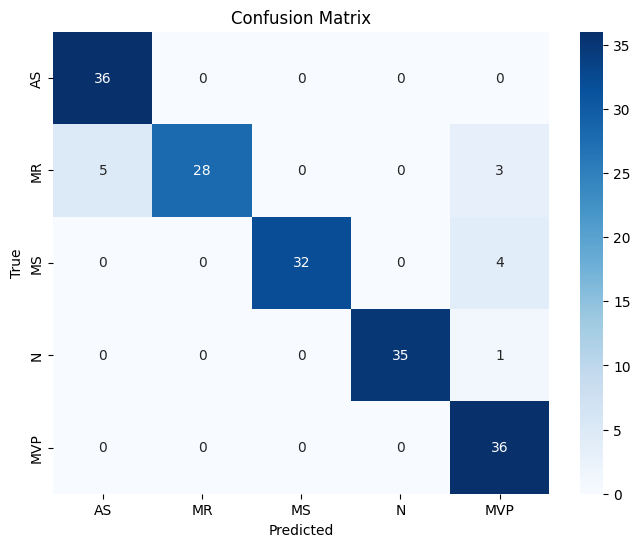

In [61]:

import pickle
import numpy as np

with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

mvp_csv_path = r"..\Dataset\continuous_audio_mfcc_features_with_labels.csv"

mvp_train_x_mfcc, mvp_train_y_mfcc, mvp_test_x_mfcc, mvp_test_y_mfcc, \
mvp_train_x_spectrogram, mvp_train_y_spectrogram, mvp_test_x_spectrogram, mvp_test_y_spectrogram, \
upd_label_encoder, _ = SplitDataset(mvp_csv_path, loaded_label_encoder)

# Function to sample data
def sample_data(X, y, sample_ratio=0.2):
    """Randomly selects a percentage of the data."""
    sample_size = int(len(X) * sample_ratio)
    indices = np.random.choice(len(X), sample_size, replace=False)
    return X[indices], y[indices]

old_x_train_mfcc, old_y_train_mfcc, old_x_test_mfcc, old_y_test_mfcc, \
old_x_train_spectrogram, old_y_train_spectrogram, old_x_test_spectrogram, old_y_test_spectrogram, \
upd_label_encoder, _ = SplitDataset(initial_csv_path, upd_label_encoder)

# Sample data from the old dataset
old_x_sample, old_y_sample = sample_data(old_x_train_spectrogram, old_y_train_spectrogram, sample_ratio=0.2)


print(old_y_train_spectrogram[3])
print(old_y_sample[3])
print(old_y_test_spectrogram[12])

print("Class Mapping in Label Encoder:")
for class_name, encoded_value in zip(upd_label_encoder.classes_, range(len(upd_label_encoder.classes_))):
    print(f"{class_name}: {encoded_value}")

combined_x_train = np.concatenate((mvp_train_x_spectrogram, old_x_sample), axis=0)
combined_y_train = np.concatenate((mvp_train_y_spectrogram, old_y_sample), axis=0)

print(f"🔹 Combined X_train shape: {combined_x_train.shape}")
print(f"🔹 Combined y_train shape: {combined_y_train.shape}")

model.add_new_label(combined_x_train, np.argmax(combined_y_train, axis=1))

X_combined_test = np.concatenate((old_x_test_spectrogram, mvp_test_x_spectrogram), axis=0)
y_combined_test = np.concatenate((old_y_test_spectrogram, mvp_test_y_spectrogram), axis=0)

model.evaluate_model(X_combined_test, np.argmax(y_combined_test, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)
